In [3]:
from google.colab import drive

# Check if Drive is already mounted
import os
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Drive is already mounted.")

Mounted at /content/drive


In [2]:
# prompt: display the content of bodo_dataset from drive

import os

# Get the path to the bodo_dataset folder
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')

# Check if the folder exists
if os.path.isdir(bodo_dataset_folder):
  # Get the list of files in the folder
  files = os.listdir(bodo_dataset_folder)

  # Print the contents of the folder
  for file in files:
    print(file)
else:
  print("The bodo_dataset folder does not exist in your Google Drive.")

1eng.txt
2eng.txt
3eng.txt
4.xlsx
2bodo.txt
3.xlsx
1bodo.txt
3bodo.txt
2.xlsx
4bodo.txt
6.xlsx
5.xlsx
4eng.txt
7.csv
bodo-mono.csv
augmented_bodo_text.txt
1eng_transliterated.txt
1.xlsx
Bodo NER dataset.txt
train_sentences.txt
test_tags.txt
train_tags.txt
test_sentences.txt
sentences.txt
tags.txt
Bodo NER dataset1.txt
train.txt
test.txt
IFSC.json
bank_details.csv
bank_details.json
bank_details1.json
transliterated_bank_details.csv
transliterated_bank_details.json
NER_tagged_bank_details.json
bodo_bank_details.jsonl
bodo_char2vec.model
bank_details.jsonl
transliterated_bank_details.jsonl
combined_ner_pos.txt
ner_tagged_bodo_data.jsonl
word_pos_ner_output.txt
combined_output.txt
bodo_sentences_labels.jsonl
bodo_word_pos_ner.csv
cleaned_bodo_text.txt
bodo_text.txt
pos_tagged_bank_details.jsonl
bodo_word_pos_ner.txt
bodo_word2vec.model
character_embedding_model
combined_bodo_data.csv
bodo_test.txt
bodo_dev.txt
bodo_train.txt
cnn_ner_model.h5
gru_ner_model.h5
lstm_ner_model.h5
bodo_char_emb

In [24]:
import pandas as pd

# Load dataset
bodo_ner_file_path = '/content/drive/My Drive/bodo datasets/bodo_ner_data.csv'

# Read CSV with ',' as the separator
data = pd.read_csv(bodo_ner_file_path, header=None, names=['Bodo Text', 'NER Tag'], sep=',')

# Ensure no missing values
data.dropna(inplace=True)

print(data.tail(10))

         Bodo Text NER Tag
104        तिरुपति   B-LOC
105         सैमसंग   B-ORG
106         टीसीएस   B-ORG
107         फेसबुक   B-ORG
108       महिंद्रा   B-ORG
109            डेल   B-ORG
110       क्वालकॉम   B-ORG
111     नेटफ्लिक्स   B-ORG
112         ट्विटर   B-ORG
113  ग्रैमी अवॉर्ड  B-MISC


In [25]:
print(data['NER Tag'].value_counts())  # Check label distribution
print(label2idx)
print(idx2label)

NER Tag
O          44
B-PER      26
B-LOC      22
B-ORG      12
B-MISC      5
B-NUM       4
NER Tag     1
Name: count, dtype: int64
{'B-LOC': 0, 'B-MISC': 1, 'B-NUM': 2, 'B-ORG': 3, 'B-PER': 4, 'NER Tag': 5, 'O': 6}
{0: 'B-LOC', 1: 'B-MISC', 2: 'B-NUM', 3: 'B-ORG', 4: 'B-PER', 5: 'NER Tag', 6: 'O'}


In [26]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import pickle  # To save/load mappings

# 🔹 Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# 🔹 Load dataset
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')
bodo_ner_file_path = os.path.join(bodo_dataset_folder, 'bodo_ner_data.csv')

# Read the CSV file (ensure correct formatting)
data = pd.read_csv(bodo_ner_file_path, header=None, names=['Bodo Text', 'NER Tag'], sep=',')

# Ensure no missing values
data.dropna(inplace=True)

# 🔹 Sort unique words and labels before indexing (Ensures consistent order)
words = sorted(set(' '.join(data['Bodo Text'].astype(str)).split()))
labels = sorted(set(data['NER Tag'].values))

# 🔹 Create word and label mappings
word2idx = {word: idx + 1 for idx, word in enumerate(words)}  # Start index from 1
word2idx['PAD'] = 0  # Padding token
idx2word = {idx: word for word, idx in word2idx.items()}

label2idx = {label: idx for idx, label in enumerate(labels)}
idx2label = {idx: label for label, idx in label2idx.items()}

# 🔹 Save mappings to a file (ensures consistent mapping when reloading the model)
mapping_file = os.path.join(bodo_dataset_folder, 'mappings.pkl')
with open(mapping_file, 'wb') as f:
    pickle.dump({'word2idx': word2idx, 'idx2word': idx2word, 'label2idx': label2idx, 'idx2label': idx2label}, f)

# Convert words and labels to sequences
X = [[word2idx[w] for w in s.split()] for s in data['Bodo Text']]  # List of word index sequences
y= [[label2idx[l] if l in label2idx else label2idx['O'] for l in s.split(' ')] for s in data['NER Tag']]   # Handle multi-token sequences

# 🔹 Pad sequences
max_len = max(len(seq) for seq in X)  # Maximum sequence length
X = pad_sequences(X, maxlen=max_len, padding='post')
y = pad_sequences(y, maxlen=max_len, padding='post')

# Convert labels to categorical format
y = np.array([to_categorical(seq, num_classes=len(label2idx)) for seq in y])  # One-hot encode labels

# 🔹 Split into training and testing sets
if len(X) >= 2:
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y.argmax(axis=-1), random_state=SEED)
    except ValueError:
        print(" Stratification not possible due to infrequent classes. Performing a random split.")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)  # Random split
else:
    print("Dataset too small for splitting. Consider adding more data.")
    X_train, X_test, y_train, y_test = X, X[:1], y, y[:1]  # Handle small dataset
# 🔹 Define the NER Model
model = Sequential([
    Embedding(input_dim=len(word2idx) + 1, output_dim=64, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    TimeDistributed(Dense(len(label2idx), activation='softmax'))
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 🔹 Train the model
model.fit(X_train, y_train, batch_size=32, epochs=5, validation_split=0.1)

# 🔹 Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# 🔹 Save the model
model_path = os.path.join(bodo_dataset_folder, "bodo_ner_model.h5")
model.save(model_path)
print(f"Model saved at {model_path}")

# 🔹 Load mappings before prediction
with open(mapping_file, 'rb') as f:
    mappings = pickle.load(f)
    word2idx = mappings['word2idx']
    idx2label = mappings['idx2label']

# 🔹 Function to Predict NER Tags
def predict_ner(sentence, model, word2idx, idx2label, max_len):
    words = sentence.split()
    seq = [word2idx.get(word, 0) for word in words]  # Convert words to indexes
    seq = pad_sequences([seq], maxlen=max_len, padding='post')  # Pad sequence

    predictions = model.predict(seq)[0]  # Predict NER tags
    predicted_labels = [idx2label[np.argmax(tag)] for tag in predictions[:len(words)]]  # Convert indexes to labels

    return list(zip(words, predicted_labels))  # Return word-label pairs

 Stratification not possible due to infrequent classes. Performing a random split.
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 813ms/step - accuracy: 0.3050 - loss: 1.9411 - val_accuracy: 0.6000 - val_loss: 1.9226
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6647 - loss: 1.9134 - val_accuracy: 0.6000 - val_loss: 1.8955
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6177 - loss: 1.8836 - val_accuracy: 0.6500 - val_loss: 1.8624
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5999 - loss: 1.8458 - val_accuracy: 0.6500 - val_loss: 1.8201
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5999 - loss: 1.7977 - val_accuracy: 0.6500 - val_loss: 1.7656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5870 - loss: 1.7642


Test Loss: 1.7642, Test Accuracy: 0.5870
Model saved at /content/drive/My Drive/bodo datasets/bodo_ner_model.h5


In [28]:
import json
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model(os.path.join(bodo_dataset_folder, "bodo_ner_model.h5"))

# Load word and label index mappings
with open(os.path.join(bodo_dataset_folder, 'mappings.pkl'), 'rb') as f:
    mappings = pickle.load(f)
    word2idx = mappings['word2idx']
    idx2label = mappings['idx2label']


def predict_ner(sentence):
    """Predicts NER tags for a given Bodo sentence."""

    # Tokenize input sentence
    words = sentence.split()

    # Convert words to indices (use 0 if word not in vocabulary)
    X_test = [[word2idx.get(word, 0)] for word in words]

    # Pad sequence to match training size
    X_padded = pad_sequences([X_test], maxlen=max_len, padding="post")

    # Predict NER tags
    predictions = model.predict(X_padded)

    # Convert predictions to labels
    predicted_tags = [idx2label[np.argmax(tag)] for tag in predictions[0]]

    # Return word-tag pairs
    return list(zip(words, predicted_tags))

# Test sentences
test_sentences = [
    "बिजय गुवाहाटी थांनोखाय जोंगाय।",
    "दिल्ली विश्वविद्यालयथांनोखाय पढ़ाय हो।",
    "टाटा मोटर्स असमथांनोखाय कारखाना खोलाय।",
    "२०२४ सालथांनोखाय नयाँ नीति लागू गोजों।"
]

# Predict NER tags
for sentence in test_sentences:
    tagged_sentence = predict_ner(sentence)
    print(tagged_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[('बिजय', 'O'), ('गुवाहाटी', 'B-LOC')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
[('दिल्ली', 'B-LOC'), ('विश्वविद्यालयथांनोखाय', 'B-LOC')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
[('टाटा', 'B-LOC'), ('मोटर्स', 'B-LOC')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
[('२०२४', 'B-LOC'), ('सालथांनोखाय', 'B-LOC')]


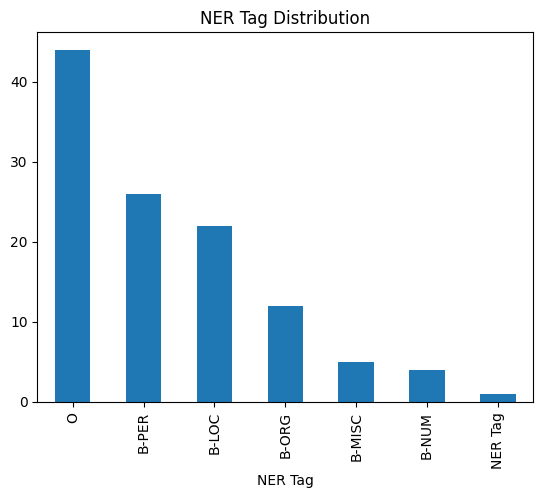

In [29]:
import matplotlib.pyplot as plt

data['NER Tag'].value_counts().plot(kind='bar')
plt.title("NER Tag Distribution")
plt.show()

In [ ]:
# prompt: load ifsc.json and perform preprocessing
import json
import pandas as pd
import os


# Get the path to the bodo_dataset folder
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')

# Assuming IFSC.json is in the bodo_dataset folder
ifsc_file_path = os.path.join(bodo_dataset_folder, 'IFSC.json')

if os.path.exists(ifsc_file_path):
    with open(ifsc_file_path, 'r') as f:
        data = json.load(f)

    # Convert the JSON data to a DataFrame
    rows = []
    for bank_code, ifsc_list in data.items():
        for ifsc in ifsc_list:
            rows.append([bank_code, ifsc])

    # Create a DataFrame with 'Bank_Code' and 'IFSC_Code' columns
    df = pd.DataFrame(rows, columns=['Bank_Code', 'IFSC_Code'])

    # Example preprocessing steps:
    # 1. Remove duplicates (though in this case, there may not be duplicates)
    df.drop_duplicates(inplace=True)

    # 2. Handle missing values if applicable (not really needed here since it's IFSC data)
    # df.fillna('Unknown', inplace=True)  # Optional if missing values are expected

    print("Preprocessed DataFrame:")
    print(df.head(10))
else:
    print("ifsc.json file does not exist in the bodo_dataset folder.")

Preprocessed DataFrame:
  Bank_Code IFSC_Code
0      ABHY     65001
1      ABHY     65002
2      ABHY     65003
3      ABHY     65004
4      ABHY     65005
5      ABHY     65006
6      ABHY     65007
7      ABHY     65008
8      ABHY     65009
9      ABHY     65010


In [ ]:
#Generating IFSC codes
def generate_ifsc(key, value):
    # Define the bank code from the key
    bank_code = key[:4].upper()  # Use the first 4 characters of the key in uppercase
    if len(bank_code) < 4:
        bank_code = bank_code.ljust(4, '0')  # Pad with zeros if less than 4

    # The fifth character is always '0'
    middle_char = '0'

    # Convert the value to a 6-digit branch code
    branch_code = str(value).zfill(6)  # Pad with zeros to make it 6 digits

    # Combine to form the IFSC code
    ifsc_code = f"{bank_code}{middle_char}{branch_code}"
    return ifsc_code

bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')

# Assuming IFSC.json is in the bodo_dataset folder
ifsc_file_path = os.path.join(bodo_dataset_folder, 'IFSC.json')

if os.path.exists(ifsc_file_path):
    with open(ifsc_file_path, 'r') as f:
        data = json.load(f)


# Generate IFSC codes
ifsc_codes = {}
for key, values in data.items():
    for value in values:
        ifsc_code = generate_ifsc(key, value)
        ifsc_codes[(key, value)] = ifsc_code

# Print generated IFSC codes
for key_value, ifsc in ifsc_codes.items():
    print(f"IFSC code for {key_value}: {ifsc}")

Streaming output truncated to the last 5000 lines.
IFSC code for ('UTIB', 'SYDC68'): UTIB0SYDC68
IFSC code for ('UTIB', 'SYDC69'): UTIB0SYDC69
IFSC code for ('UTIB', 'SYDC70'): UTIB0SYDC70
IFSC code for ('UTIB', 'SYDC71'): UTIB0SYDC71
IFSC code for ('UTIB', 'SYDC72'): UTIB0SYDC72
IFSC code for ('UTIB', 'SYDC73'): UTIB0SYDC73
IFSC code for ('UTIB', 'SYDC74'): UTIB0SYDC74
IFSC code for ('UTIB', 'SYDC75'): UTIB0SYDC75
IFSC code for ('UTIB', 'SYDC76'): UTIB0SYDC76
IFSC code for ('UTIB', 'SYDC77'): UTIB0SYDC77
IFSC code for ('UTIB', 'SYDC78'): UTIB0SYDC78
IFSC code for ('UTIB', 'SYDC79'): UTIB0SYDC79
IFSC code for ('UTIB', 'SYDC80'): UTIB0SYDC80
IFSC code for ('UTIB', 'SYDC81'): UTIB0SYDC81
IFSC code for ('UTIB', 'SYDC82'): UTIB0SYDC82
IFSC code for ('UTIB', 'SYDC83'): UTIB0SYDC83
IFSC code for ('UTIB', 'SYDC84'): UTIB0SYDC84
IFSC code for ('UTIB', 'SYDC85'): UTIB0SYDC85
IFSC code for ('UTIB', 'SYDC86'): UTIB0SYDC86
IFSC code for ('UTIB', 'SYDC87'): UTIB0SYDC87
IFSC code for ('UTIB', 'SYDC8

In [ ]:
#accessing bank details using IFSC codes
import json
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
import os
import time

# Function to fetch bank details using IFSC code
def fetch_bank_details(ifsc_code):
    URL = "https://ifsc.razorpay.com/"
    try:
        response = requests.get(URL + str(ifsc_code), timeout=5)  # Timeout for slow requests
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Failed to fetch details for IFSC code {ifsc_code}: {response.status_code}")
            return None
    except requests.RequestException as e:
        print(f"Error for IFSC {ifsc_code}: {e}")
        return None

# Function to process IFSC codes concurrently
def fetch_all_bank_details(ifsc_codes, max_workers=100):
    all_bank_details = []

    # Use ThreadPoolExecutor to manage concurrent requests
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_ifsc = {executor.submit(fetch_bank_details, ifsc): ifsc for key_value, ifsc in ifsc_codes.items()}
        for future in as_completed(future_to_ifsc):
            ifsc = future_to_ifsc[future]
            try:
                bank_details = future.result()
                if bank_details:
                    all_bank_details.append(bank_details)
            except Exception as exc:
                print(f"IFSC code {ifsc} generated an exception: {exc}")

    return all_bank_details

# Define the Bodo dataset folder path (adjust the path as per your system)
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')

# Assuming IFSC.json is in the Bodo dataset folder
ifsc_file_path = os.path.join(bodo_dataset_folder, 'IFSC.json')

# Check if the IFSC file exists and load the data
if os.path.exists(ifsc_file_path):
    with open(ifsc_file_path, 'r') as f:
        data = json.load(f)
        ifsc_codes = data.get('ifsc_codes', [])  # Replace with the actual key where IFSC codes are stored
else:
    print(f"IFSC file not found at {ifsc_file_path}")
    exit()

# Generate IFSC codes
ifsc_codes = {}
for key, values in data.items():
    for value in values:
        ifsc_code = generate_ifsc(key, value)  # Assuming generate_ifsc() is defined elsewhere
        ifsc_codes[(key, value)] = ifsc_code

# Process in batches to avoid rate limiting
batch_size = 10000
output_file = os.path.join(bodo_dataset_folder, "bank_details.jsonl")  # Using JSONL format for appending

# Process each batch of IFSC codes
for i in range(0, len(ifsc_codes), batch_size):
    batch_ifsc_codes = dict(list(ifsc_codes.items())[i:i + batch_size])
    bank_details_list = fetch_all_bank_details(batch_ifsc_codes, max_workers=100)

    # Save each batch incrementally in JSON Lines format (one JSON object per line)
    with open(output_file, 'a') as f:
        for bank_detail in bank_details_list:
            f.write(json.dumps(bank_detail) + "\n")  # Writing each object on a new line

    print(f"Fetched and saved bank details for batch {i//batch_size + 1}")

    # Short delay to avoid overwhelming the server
    time.sleep(5)  # 5-second delay between batches

print(f"All bank details saved to {output_file}")


Failed to fetch details for IFSC code ASBL0000026: 404
Failed to fetch details for IFSC code ASBL0000061: 404
Failed to fetch details for IFSC code ASBL0000056: 404
Fetched and saved bank details for batch 1
Fetched and saved bank details for batch 2
Fetched and saved bank details for batch 3
Fetched and saved bank details for batch 4
Failed to fetch details for IFSC code GSCB0USSNBL: 404
Fetched and saved bank details for batch 5
Failed to fetch details for IFSC code HDFC0001661: 404
Failed to fetch details for IFSC code HDFC0CRAJ02: 404
Failed to fetch details for IFSC code HDFC0CRAJ01: 404
Failed to fetch details for IFSC code HDFC0CRAJ03: 404
Failed to fetch details for IFSC code HDFC0CRAJ08: 404
Failed to fetch details for IFSC code HDFC0CRAJ10: 404
Failed to fetch details for IFSC code HDFC0CRAJ05: 404
Failed to fetch details for IFSC code HDFC0CRAJ06: 404
Failed to fetch details for IFSC code HDFC0CRAJ11: 404
Failed to fetch details for IFSC code HDFC0CRAJ16: 404
Failed to fetch

In [ ]:
pip install indic-transliteration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 2.8 MB/s eta 0:00:00


In [ ]:
# prompt: transliterate the all bank details into bodo language using indic transliteration
import os
import json
from indic_transliteration import sanscript
from indic_transliteration.sanscript import transliterate

# Define the file paths
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')
bank_details_file = os.path.join(bodo_dataset_folder, "bank_details.jsonl")
transliterated_file = os.path.join(bodo_dataset_folder, "transliterated_bank_details.jsonl")

# Check if the bank details file exists
if os.path.exists(bank_details_file):
    # Initialize a list to hold all the bank details (since it's a JSONL file)
    bank_details_list = []

    # Read the bank details from the JSONL file
    with open(bank_details_file, 'r') as f:
        for line in f:
            bank_details_list.append(json.loads(line))

    # Open the output file for writing transliterated data
    with open(transliterated_file, 'w') as transliterated_f:
        # Process each set of bank details and transliterate them
        for bank_details in bank_details_list:
            transliterated_details = {}

            # Transliterate each detail to Bodo (Devanagari script)
            for key, value in bank_details.items():
                if isinstance(value, str):  # Ensure the value is a string for transliteration
                    transliterated_details[key] = transliterate(value, sanscript.ITRANS, sanscript.DEVANAGARI)
                else:
                    transliterated_details[key] = value  # Keep the original value if not a string

            # Write the transliterated details to the output JSONL file
            transliterated_f.write(json.dumps(transliterated_details) + '\n')

    print(f"Transliterated data saved to {transliterated_file}")

else:
    print(f"File {bank_details_file} does not exist.")


Transliterated data saved to /content/drive/My Drive/bodo datasets/transliterated_bank_details.jsonl


In [ ]:
with open('/content/drive/My Drive/bodo datasets/transliterated_bank_details.jsonl', 'r') as f:
  data = [] # Create an empty list to store the data
  for line in f: # Iterate over each line in the file
    data.append(json.loads(line)) # Parse each line as a JSON object and append it to the list
  print(len(data))

401447


In [ ]:
# prompt: access the starting lines of transliterated data
import json

with open('/content/drive/My Drive/bodo datasets/transliterated_bank_details.jsonl', 'r') as f:
    for i in range(5):  # Read the first 5 lines
        line = f.readline()
        if line:
            try:
                print(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
        else:
            break # Exit loop if no more lines


{'MICR': '४२२८८५५०३', 'BRANCH': 'ऱाज़ूऱ्', 'ADDRESS': 'POष्ट् ऱाज़ूऱ् टाळ् आख़्Oळा ४२२६०४', 'STATE': 'ंआःआऱाष्ःट्ऱा', 'CONTACT': '+९१२४२४२५१०३०', 'UPI': False, 'RTGS': True, 'CITY': 'आःंEड्णाग़ाऱ्', 'CENTRE': 'ऱाज़ूऱ्', 'DISTRICT': 'ऱाज़ूऱ्', 'NEFT': True, 'IMPS': True, 'SWIFT': None, 'ISO3166': 'ईण्-ंः', 'BANK': 'आह्मेद्नगर् डिस्त्रिच्त् छेन्त्रल् छो-ओपेरतिवे Bअन्क्', 'BANKCODE': 'आःड्छ्', 'IFSC': 'आःड्छ्००००१४३'}
{'ISO3166': 'ईण्-ंः', 'MICR': '४०००६५०५२', 'BRANCH': 'ंईऱा ऱ्Oआड् (Eआष्ट्)', 'UPI': True, 'CONTACT': '+९१२२२८५५५२४४', 'DISTRICT': 'ट्ःआण्E', 'SWIFT': None, 'RTGS': True, 'CITY': 'Bःआय़ाण्डाऱ्', 'STATE': 'ंआःआऱाष्ःट्ऱा', 'NEFT': True, 'CENTRE': 'ट्ःआण्E', 'IMPS': True, 'ADDRESS': 'ष्ःOP ण्O। ६,७ & ८, ग़्ऱ्Oऊण्ड् Fळ्OOऱ्, Bऊईळ्डीण्ग़् ण्O। आ-६३, ष्Eछ्ट्Oऱ् - १, ष्ःआण्टी णाग़ाऱ्, ंईऱा ऱ्Oआड् (E), डीष्ट् ट्ःआण्E ४०११०७।', 'BANK': 'आभ्युदय छो-ओपेरतिवे Bअन्क्', 'BANKCODE': 'आBःय़्', 'IFSC': 'आBःय़्००६५०५२'}
{'CONTACT': '', 'NEFT': True, 'UPI': False, 'ISO3166': 'ईण्-ट्ग़्', 'CENTRE': 'ःय़्ड्Eऱा

In [ ]:
# prompt: convert aboce data into a data frame with sentence no,words list and tag list

import pandas as pd
import json

# Load data from the JSON file
with open('output_bio_format.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Create a list to store the data for the DataFrame
rows = []
for i, entry in enumerate(data):
    rows.append({
        'Sentence No': i + 1,
        'Words': entry['Word'].split(','),
        'Tag List': [','.join(entry['BIO Tag'])]  # Join the tags into a space-separated string
    })

# Create the DataFrame
df = pd.DataFrame(rows)

# Print or use the DataFrame
df.head(20)



,Sentence No,Words,Tag List
0,1,[४२२८८५५०३ ऱाज़ूऱ् POष्ट् ऱाज़ूऱ् टाळ् आख़्Oळा ४२...,"[B-MICR,B-BRANCH,B-ADDRESS,I-ADDRESS,I-ADDRESS..."
1,2,[ईण्-ंः ४०००६५०५२ ंईऱा ऱ्Oआड् (Eआष्ट्) +९१२२२८...,"[B-ISO3166,B-MICR,B-BRANCH,I-BRANCH,I-BRANCH,B..."
2,3,[ईण्-ट्ग़् ःय़्ड्EऱाBआड् ट्ण्-ईBट्ट्Fय़्Pट्ण्०३/P...,"[B-ISO3166,B-CENTRE,B-ADDRESS,B-BRANCH,B-MICR,..."
3,4,[४१४८८५५८३ य़्Eळी POष्ट् य़्Eळी टाळ् Pआट्ःआऱ्डी ...,"[B-MICR,B-BRANCH,B-ADDRESS,I-ADDRESS,I-ADDRESS..."
4,5,[४१३८८५३७६ ऱाःऊऱी ट्OWण् POष्ट् ऱाःऊऱी ट्OWण् ...,"[B-MICR,B-BRANCH,I-BRANCH,B-ADDRESS,I-ADDRESS,..."
5,6,[४२३८८५५२६ ंआःEग़ाOण् ड्Eष्ःंऊख़्ः POष्ट् ंआःEग़ा...,"[B-MICR,B-BRANCH,I-BRANCH,B-ADDRESS,I-ADDRESS,..."
6,7,[४२३८८५५२३ Wआऱी POष्ट् Wआऱी टाळ् ख़्OPEऱ्ग़ाOण् ...,"[B-MICR,B-BRANCH,B-ADDRESS,I-ADDRESS,I-ADDRESS..."
7,8,[४१३८८५५४८ ऱाःऊऱी ख़्ः POष्ट् ऱाःऊऱी ख़्ःऊऱ्ड् ट...,"[B-MICR,B-BRANCH,I-BRANCH,B-ADDRESS,I-ADDRESS,..."
8,9,[४१४८८५००९ Fआख़ीऱ्Wआडा POष्ट् Fआख़ीऱ्Wआडा णाग़ाऱ्...,"[B-MICR,B-BRANCH,B-ADDRESS,I-ADDRESS,I-ADDRESS..."
9,10,[४१४८८५५०८ Wआळ्ख़ी POष्ट् Wआळ्ख़ी टाळ् णाग़ाऱ् ४१...,"[B-MICR,B-BRANCH,B-ADDRESS,I-ADDRESS,I-ADDRESS..."


In [ ]:
# prompt: save above dataframe into json

# Save the DataFrame to a JSON file
df.to_json('/content/drive/My Drive/bodo datasets/bank_details_dataframe.json', orient='records', lines=True)

In [ ]:
# prompt: access words  and  tags from bank_details_dataframe.json and save the output

# prompt: access words  and  tags from bank_details_dataframe.json and save the output

import json
import pandas as pd

# Load data from the JSON file
import json
import os

# File paths
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')
bank_details_file_path = os.path.join(bodo_dataset_folder, "bank_details_dataframe.json")
final_data_file_path = os.path.join(bodo_dataset_folder, "final_bank_data.json")

try:
    # Load data from the bank_details_dataframe.json file
    with open(bank_details_file_path, 'r', encoding='utf-8') as f:
        data = []
        for line in f:
            data.append(json.loads(line))

    final_data = []
    for item in data:
        words = item['Words']  # Assuming 'Words' is a list of words
        ner_tags = item['Tag List']  # Assuming 'Tag List' is a list of NER tags

        # Ensure both lists have the same length
        min_len = min(len(words), len(ner_tags))
        words = words[:min_len]
        ner_tags = ner_tags[:min_len]

        final_data.append({
            "words": words,
            "ner_tags": ner_tags
        })

    # Save the final data to a new JSON file
    with open(final_data_file_path, 'w', encoding='utf-8') as f:
        json.dump(final_data, f, indent=4, ensure_ascii=False)

    print(f"Final data saved to {final_data_file_path}")

except FileNotFoundError:
    print(f"Error: File '{bank_details_file_path}' not found.")
except json.JSONDecodeError as e:
    print(f"Error decoding JSON from '{bank_details_file_path}': {e}")
except Exception as e:
    print(f"An error occurred: {e}")

Final data saved to /content/drive/My Drive/bodo datasets/final_bank_data.json


In [ ]:
# prompt: print starting lines of final_bodo_data.json

# Load data from the JSON file
with open('/content/drive/My Drive/bodo datasets/final_bank_data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Print the first few lines of the data
for i in range(5):  # Print the first 5 lines (adjust as needed)
  print(data[i])

{'words': ['४२२८८५५०३ ऱाज़ूऱ् POष्ट् ऱाज़ूऱ् टाळ् आख़्Oळा ४२२६०४ ंआःआऱाष्ःट्ऱा +९१२४२४२५१०३० आःंEड्णाग़ाऱ् ऱाज़ूऱ् ऱाज़ूऱ् ईण्-ंः आह्मेद्नगर् डिस्त्रिच्त् छेन्त्रल् छो-ओपेरतिवे Bअन्क् आःड्छ् आःड्छ्००००१४३'], 'ner_tags': ['B-MICR,B-BRANCH,B-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,B-STATE,B-CONTACT,B-CITY,B-CENTRE,B-DISTRICT,B-ISO3166,B-BANK,I-BANK,I-BANK,I-BANK,I-BANK,B-BANKCODE,B-IFSC']}
{'words': ['ईण्-ंः ४०००६५०५२ ंईऱा ऱ्Oआड् (Eआष्ट्) +९१२२२८५५५२४४ ट्ःआण्E Bःआय़ाण्डाऱ् ंआःआऱाष्ःट्ऱा ट्ःआण्E ष्ःOP ण्O। ६'], 'ner_tags': ['B-ISO3166,B-MICR,B-BRANCH,I-BRANCH,I-BRANCH,B-CONTACT,B-DISTRICT,B-CITY,B-STATE,B-CENTRE,B-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,B-BANK,I-BANK,I-BANK,B-BANKCODE,B-IFSC']}
{'words': ['ईण्-ट्ग़् ःय़्ड्EऱाBआड् ट्ण्-ईBट्ट्Fय़्Pट्ण्०३/Pट्०४ंVट्Wष्ःईP-Bण्षीग़ीण्षीग़ींईछीPईट्य़्ख़्Vऱ्ग़्ऱ्य़्डीष्टीछ्ट्ट्ग़्५०००७५ णाऱ

In [ ]:
with open('/content/drive/My Drive/bodo datasets/final_bank_data.json', 'r') as f:
    for i in range(20):  # Read the first 5 lines
        line = f.readline()
        if line:
            print(line, end="") #Added end="" to prevent extra newlines
        else:
            break

[
    {
        "words": [
            "४२२८८५५०३ ऱाज़ूऱ् POष्ट् ऱाज़ूऱ् टाळ् आख़्Oळा ४२२६०४ ंआःआऱाष्ःट्ऱा +९१२४२४२५१०३० आःंEड्णाग़ाऱ् ऱाज़ूऱ् ऱाज़ूऱ् ईण्-ंः आह्मेद्नगर् डिस्त्रिच्त् छेन्त्रल् छो-ओपेरतिवे Bअन्क् आःड्छ् आःड्छ्००००१४३"
        ],
        "ner_tags": [
            "B-MICR B-BRANCH B-ADDRESS I-ADDRESS I-ADDRESS I-ADDRESS I-ADDRESS B-STATE B-CONTACT B-CITY B-CENTRE B-DISTRICT B-ISO3166 B-BANK I-BANK I-BANK I-BANK I-BANK B-BANKCODE B-IFSC"
        ]
    },
    {
        "words": [
            "ईण्-ंः ४०००६५०५२ ंईऱा ऱ्Oआड् (Eआष्ट्) +९१२२२८५५५२४४ ट्ःआण्E Bःआय़ाण्डाऱ् ंआःआऱाष्ःट्ऱा ट्ःआण्E ष्ःOP ण्O। ६,७ & ८, ग़्ऱ्Oऊण्ड् Fळ्OOऱ्, Bऊईळ्डीण्ग़् ण्O। आ-६३, ष्Eछ्ट्Oऱ् - १, ष्ःआण्टी णाग़ाऱ्, ंईऱा ऱ्Oआड् (E), डीष्ट् ट्ःआण्E ४०११०७। आभ्युदय छो-ओपेरतिवे Bअन्क् आBःय़् आBःय़्००६५०५२"
        ],
        "ner_tags": [
            "B-ISO3166 B-MICR B-BRANCH I-BRANCH I-BRANCH B-CONTACT B-DISTRICT B-CITY B-STATE B-CENTRE B-ADDRESS I-ADDRESS I-ADDRESS I-ADDRESS I-ADDRESS I-ADDRESS I-ADDRESS I-ADDRESS I-AD

In [ ]:
# prompt: print starting lines of combined_bodo_data.json

import json

# File path
file_path = '/content/drive/My Drive/bodo datasets/combined_bodo_data.json'

try:
    with open(file_path, 'r') as f:
        data = json.load(f)
        for i in range(5):  # Print the first 5 lines (adjust as needed)
            print(data[i])
except FileNotFoundError:
    print(f"Error: File '{file_path}' not found.")
except json.JSONDecodeError as e:
    print(f"Error decoding JSON from '{file_path}': {e}")
except Exception as e:
    print(f"An error occurred: {e}")

{'words': ['४२२८८५५०३ ऱाज़ूऱ् POष्ट् ऱाज़ूऱ् टाळ् आख़्Oळा ४२२६०४ ंआःआऱाष्ःट्ऱा +९१२४२४२५१०३० आःंEड्णाग़ाऱ् ऱाज़ूऱ् ऱाज़ूऱ् ईण्-ंः आह्मेद्नगर् डिस्त्रिच्त् छेन्त्रल् छो-ओपेरतिवे Bअन्क् आःड्छ् आःड्छ्००००१४३'], 'ner_tags': ['B-MICR,B-BRANCH,B-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,B-STATE,B-CONTACT,B-CITY,B-CENTRE,B-DISTRICT,B-ISO3166,B-BANK,I-BANK,I-BANK,I-BANK,I-BANK,B-BANKCODE,B-IFSC']}
{'words': ['ईण्-ंः ४०००६५०५२ ंईऱा ऱ्Oआड् (Eआष्ट्) +९१२२२८५५५२४४ ट्ःआण्E Bःआय़ाण्डाऱ् ंआःआऱाष्ःट्ऱा ट्ःआण्E ष्ःOP ण्O। ६'], 'ner_tags': ['B-ISO3166,B-MICR,B-BRANCH,I-BRANCH,I-BRANCH,B-CONTACT,B-DISTRICT,B-CITY,B-STATE,B-CENTRE,B-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,B-BANK,I-BANK,I-BANK,B-BANKCODE,B-IFSC']}
{'words': ['ईण्-ट्ग़् ःय़्ड्EऱाBआड् ट्ण्-ईBट्ट्Fय़्Pट्ण्०३/Pट्०४ंVट्Wष्ःईP-Bण्षीग़ीण्षीग़ींईछीPईट्य़्ख़्Vऱ्ग़्ऱ्य़्डीष्टीछ्ट्ट्ग़्५०००७५ णाऱ

In [ ]:
pip install spacy

In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 51.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
#Tokenization of bodo data into sentences
import re
import os
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag


# Set up dataset folder path
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')

# Get the path to the bodo text file
bodo_text_path = os.path.join(bodo_dataset_folder, 'bodo_text.txt')

def bodo_sentence_tokenizer(text):
    # This regex will split the text into sentences based on common sentence-ending punctuation
    sentences = re.split(r'(?<=[।!?]) +', text)
    return sentences

# Check if the file exists
if os.path.isfile(bodo_text_path):
    # Open the file and read the data
    with open(bodo_text_path, 'r') as f:
        bodo_text = f.read()

    # Sentence Tokenization
    sentences = bodo_sentence_tokenizer(bodo_text)
    for s in sentences:
        print("Sentences:", s)

Streaming output truncated to the last 5000 lines.
महाराष्ट्रआ गरम, अखा आरो गोजांनाय बोथोरफोर आरो रानस्राव गोलोम बोथोरफोरजों मोनसे क्रान्तियारि मौसुमी बारहावानि मोनदांथि मोनो।
रायजोआव मोनथाम गोनांथार जिब भुमखौराङारि ओनसोलफोर दङ, मख'जाथावै सोनाबारि गाथोन, देक्कान जौयेन आरो सोनाब बोरिमा।
बे रायजोआव मोन्नो हानाय गुबुन जुनारफोरनि गेजेराव मानबायग्रा जिब, जेरै थिखथिखा, देवखाखर आरो जिबौनि हारिसाफोर, जेरै फिथिगम आरो क्रेट बायदि बायदिफोर दङ।
बेयाव सेगुन, पाइन, अक, युनिंथौ, लेइहाव, औवा आरो रायदोंनि अरनफोर दङ।
बे रायजोआ हायुंआरि मोसा संरैखाथि बिगुमानि सिङाव मोनद' रान्नानै होनाय मोसा रिसार्भफोरनि गेजेरजों बिनि मोसाफोरनि सुबुं अनजिमाखौ आइनारि रैखाथि होयो।
जिल्लाफोरखौ महखुमायारि मेजिस्ट्रेफोरजों खुंजानाय महखुमा आरो ब्लकफोरबायदि फिसासिनाव बोखावनाय जायो।
मोनसे ब्लकआव पन्चायतफोर (गामि गौथुमफोर) आरो नोगोर खुंग्राफोर थायो।
तालुकाफोरा जिल्ला थाखोआव जिल्ला परिषद आरो गाहायसिन थाखोआव गामि पन्चायतनि गेजेरारि थाखोनि पन्चायत।
महाराष्ट्रनि गासै सुबुं अनजिमाफोरनि गेजेराव 45.22 जौखोन्दो सुबुंफोरा नोगोरारि ओनसोलफोर

In [ ]:
# Download necessary NLTK resources (only need to run once)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
#Tokenization of sentences and removal of punctuations
import re
import string
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

# Download necessary NLTK resources if you haven't already
nltk.download('punkt')

# Define ASCII punctuation (standard punctuation)
ascii_punctuation = string.punctuation

# Define Devanagari punctuation and additional characters like quotes
devanagari_punctuation = "॥“”‘’"

# Combine ASCII and Devanagari punctuation
all_punctuation = ascii_punctuation + devanagari_punctuation

# Create a regex pattern to identify words that contain any punctuation
punctuation_pattern = re.compile(f"[{re.escape(all_punctuation)}]")

def remove_words_with_punctuation(tagged_sentences):
    cleaned_sentences = []
    for sentence in tagged_sentences:
        cleaned_sentence = [
             word for word in sentence
            if not punctuation_pattern.search(word)
        ]
        cleaned_sentences.append(cleaned_sentence)
    return cleaned_sentences

def tokenize_and_clean_sentences(file_path):
    try:
        with open(file_path, 'r') as file:
            text = file.read()
            sentences = sent_tokenize(text)  # Tokenize into sentences
            for sentence in sentences:
                tokens = word_tokenize(sentence)  # Tokenize into words
                # Remove words containing punctuation
                cleaned_sentence = remove_words_with_punctuation([tokens])
                print(cleaned_sentence)
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")

# Example usage
file_path = "/content/drive/My Drive/bodo datasets/bodo_text.txt"  # Replace with your file path
tokenize_and_clean_sentences(file_path)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# prompt: add the above cleaned sentences into a file
import os
import re
import string

# Define the file paths
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')
input_file_path = os.path.join(bodo_dataset_folder, "bodo_text.txt")  # Input file
output_file_path = os.path.join(bodo_dataset_folder, "cleaned_bodo_data.json")  # Output file

# Define ASCII and Devanagari punctuation
ascii_punctuation = string.punctuation
devanagari_punctuation = "।॥“”‘’"
all_punctuation = ascii_punctuation + devanagari_punctuation

# Create a regex pattern to identify words that contain any punctuation (excluding '।')
punctuation_pattern = re.compile(f"[{re.escape(all_punctuation.replace('।', ''))}]")

def remove_words_with_punctuation(tokens):
    """Remove words that contain punctuation, excluding '।'."""
    return [word for word in tokens if not punctuation_pattern.search(word)]

def split_sentences_by_delimiter(text, delimiter="।"):
    """Split the text into sentences using a custom delimiter and retain the delimiter."""
    sentences = re.split(f"({re.escape(delimiter)})", text)
    combined_sentences = []

    # Recombine the sentences with the delimiter
    for i in range(0, len(sentences) - 1, 2):
        combined_sentences.append(sentences[i].strip() + sentences[i + 1])

    # Handle any remaining part (if the text doesn't end with the delimiter)
    if len(sentences) % 2 != 0:
        combined_sentences.append(sentences[-1].strip())

    return [sentence for sentence in combined_sentences if sentence.strip()]

def tokenize_and_clean_sentences(input_file_path, output_file_path):
    """Tokenize the sentences from the input file using '।', clean them, and write to the output file."""
    try:
        with open(input_file_path, 'r', encoding='utf-8') as infile, open(output_file_path, 'w', encoding='utf-8') as outfile:
            text = infile.read()
            sentences = split_sentences_by_delimiter(text, delimiter="।")  # Split using '।' and retain it

            for sentence in sentences:
                tokens = sentence.split()  # Simple tokenization by splitting on whitespace
                cleaned_tokens = remove_words_with_punctuation(tokens)  # Remove words with punctuation (excluding '।')

                if cleaned_tokens:  # Ensure the cleaned sentence is not empty
                    cleaned_sentence = " ".join(cleaned_tokens)
                    outfile.write(cleaned_sentence + "\n")  # Write to output file

            print(f"Cleaned data has been saved to {output_file_path}")

    except FileNotFoundError:
        print(f"Error: File '{input_file_path}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Run the function
tokenize_and_clean_sentences(input_file_path, output_file_path)


Cleaned data has been saved to /content/drive/My Drive/bodo datasets/cleaned_bodo_data.json


In [ ]:
# prompt: print starting lines of cleaned_bodo_data.json

with open('/content/drive/My Drive/bodo datasets/cleaned_bodo_data.json', 'r') as f:
    for i in range(5):  # Read the first 5 lines
        line = f.readline()
        if line:
            try:
                print(line)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
        else:
            break # Exit loop if no more lines

बावैसो बोसोरफोराव खमलायनायनि बे रोखोमा गुबुन हादोरफोरावबो मुदांखा जानो हमदों।

बायदिरोखोमनि जाठिआव मिश्रा आरो संकीरना थायो।

सान्नाय खामानियाव मोनसे टेप एबा आखाइ खबनाय जायनि उनाव फुरा लय चक्रनि सान्नाय जायो।

बेखौ खालामनायाव मोनसे टेप एबा आखाइ खबनाय जायनि उनाव मोनसे वीचू थायो।

मोनसे कॉन्सर्टआव गाहायै एबा पल्लवी आरो थिलानाजों कीर्थनम थाफायो।



In [ ]:
!pip install indic-transliteration

  Using cached indic_transliteration-2.3.69-py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 kB 3.2 MB/s eta 0:00:00


In [ ]:
# prompt: transliterate above cleaned data using AI4Bharat models
import os
import json
from indic_transliteration import sanscript
from indic_transliteration.sanscript import transliterate

def transliterate_bodo(text):
    """Transliterate Bodo text (Devanagari) to English (ITRANS)."""
    return transliterate(text, sanscript.DEVANAGARI, sanscript.ITRANS)

def transliterate_bodo_file(input_file_path, output_file_path):
    """Transliterate Bodo text from a file and save results in sentence format without extra blank lines."""
    try:
        with open(input_file_path, "r", encoding="utf-8") as infile, open(output_file_path, "w", encoding="utf-8") as outfile:
            for line in infile:
                line = line.strip()
                if line:
                    transliterated_text = transliterate_bodo(line)  # Transliterate the entire sentence
                    outfile.write(transliterated_text + "\n")  # Write each sentence on a new line

            print(f"Transliterated data saved to {output_file_path}")

    except FileNotFoundError:
        print(f"Error: Input file '{input_file_path}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Define input and output file paths
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')
input_file_path = os.path.join(bodo_dataset_folder, "cleaned_bodo_data.json")
output_file_path = os.path.join(bodo_dataset_folder, "transliterated_text_bodo_data.json")

# Run transliteration
transliterate_bodo_file(input_file_path, output_file_path)


Transliterated data saved to /content/drive/My Drive/bodo datasets/transliterated_text_bodo_data.json


In [ ]:
# prompt: print first 5 lines of above file

with open('/content/drive/My Drive/bodo datasets/transliterated_text_bodo_data.json', 'r') as f:
    for i in range(10):  # Read the first 5 lines
        line = f.readline()
        if line:
            try:
                print(line)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
        else:
            break # Exit loop if no more lines


bAvaiso bosoraphorAva khamalAyanAyani be rokhomA gubuna hAdoraphorAvabo mudAMkhA jAno hamadoM|

bAyadirokhomani jAThiAva mishrA Aro saMkIranA thAyo|

sAnnAya khAmAniyAva monase Tepa ebA AkhAi khabanAya jAyani unAva phurA laya chakrani sAnnAya jAyo|

bekhau khAlAmanAyAva monase Tepa ebA AkhAi khabanAya jAyani unAva monase vIchU thAyo|

monase kaॉnsarTaAva gAhAyai ebA pallavI Aro thilAnAjoM kIrthanama thAphAyo|

1941Ava jhUlAni jerAva bithA~NA lIlA chiTanesajoM logoAva phAva jAya bithAMkhau bai mugAni bayanikhrui phothAyajAthAva phAvakhuMguraphorani gejerAva sAse maharai gAyasanadoMmona|

gubuna mulugasoloMsAliphorajoM logose jammU AbAda bigiyAna Aro biroMdArimina shrI mAtA vaiShNo devI islAmika bigiyAna Aro biroMdArimina mulugasoloMsAli daM|

be gomothAva bhumakhaurA~NA phAmuvAri mugAni unamonathAi jerAva puDucherIA phrAnsayAri bhAratani simAkhau hamathAnA donadoMmona|

AsAmAva rAyajoni AvathAyAva thAnAya dUradarshanani monathAma sArvajanika sevA prasAraNa sTeshana guvAhATI Aro silachar

In [ ]:
!pip install transformers datasets torch


  Using cached transformers-4.49.0-py3-none-any.whl.metadata (44 kB)
  Using cached datasets-3.3.2-py3-none-any.whl.metadata (19 kB)
  Using cached torch-2.6.0-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
Using cached transformers-4.49.0-py3-none-any.whl (10.0 MB)
Using cached datasets-3.3.2-py3-none-any.whl (485 kB)
Using cached torch-2.6.0-cp311-cp311-manylinux1_x86_64.whl (766.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.1+cu124 requires torch==2.5.1, but you have torch 2.6.0 which is incompatible.
torchvision 0.20.1+cu124 requires torch==2.5.1, but you have torch 2.6.0 which is incompatible.
fastai 2.7.18 requires torch<2.6,>=1.10, but you have torch 2.6.0 which is incompatible.


In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
# prompt: adding POS tags above cleaned data and save it

import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Download required NLTK data if not already present
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

def add_pos_tags(input_file_path, output_file_path):
    try:
        with open(input_file_path, 'r', encoding='utf-8') as infile, \
                open(output_file_path, 'w', encoding='utf-8') as outfile:
            for line in infile:
                line = line.strip()
                if line:  # Skip empty lines
                    tokens = word_tokenize(line)
                    pos_tags = pos_tag(tokens)
                    outfile.write(str(pos_tags) + '\n')
        print(f"POS tags added and saved to {output_file_path}")

    except FileNotFoundError:
        print(f"Error: File '{input_file_path}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage (replace with your file paths)
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')
input_file_path = os.path.join(bodo_dataset_folder, "transliterated_text_bodo_data.json")
output_file_path = os.path.join(bodo_dataset_folder, "pos_tagged_bodo_data.json")

add_pos_tags(input_file_path, output_file_path)

POS tags added and saved to /content/drive/My Drive/bodo datasets/pos_tagged_bodo_data.json


In [ ]:
# prompt: print starting lines of above pos tagged data

with open('/content/drive/My Drive/bodo datasets/pos_tagged_bodo_data.json', 'r') as f:
    for i in range(5):  # Read the first 5 lines
        line = f.readline()
        if line:
            try:
                print(line)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
        else:
            break # Exit loop if no more lines

[('bAvaiso', 'NN'), ('bosoraphorAva', 'NN'), ('khamalAyanAyani', 'NN'), ('be', 'VB'), ('rokhomA', 'VBN'), ('gubuna', 'JJ'), ('hAdoraphorAvabo', 'NN'), ('mudAMkhA', 'NN'), ('jAno', 'NN'), ('hamadoM|', 'NN')]

[('bAyadirokhomani', 'NN'), ('jAThiAva', 'NN'), ('mishrA', 'NN'), ('Aro', 'NNP'), ('saMkIranA', 'NN'), ('thAyo|', 'NN')]

[('sAnnAya', 'NN'), ('khAmAniyAva', 'NN'), ('monase', 'NN'), ('Tepa', 'NNP'), ('ebA', 'NN'), ('AkhAi', 'NNP'), ('khabanAya', 'NNP'), ('jAyani', 'NN'), ('unAva', 'JJ'), ('phurA', 'NN'), ('laya', 'NN'), ('chakrani', 'NN'), ('sAnnAya', 'NN'), ('jAyo|', 'NN')]

[('bekhau', 'NN'), ('khAlAmanAyAva', 'NN'), ('monase', 'NN'), ('Tepa', 'NNP'), ('ebA', 'NN'), ('AkhAi', 'NNP'), ('khabanAya', 'NNP'), ('jAyani', 'NN'), ('unAva', 'JJ'), ('monase', 'NN'), ('vIchU', 'NN'), ('thAyo|', 'NN')]

[('monase', 'NN'), ('kaॉnsarTaAva', 'NN'), ('gAhAyai', 'NN'), ('ebA', 'NN'), ('pallavI', 'NN'), ('Aro', 'NNP'), ('thilAnAjoM', 'NN'), ('kIrthanama', 'NN'), ('thAphAyo|', 'NN')]



In [ ]:
!python -m spacy download xx_ent_wiki_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 75.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('xx_ent_wiki_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# prompt: install torchvision

!pip install torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 801.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 2.0 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.0
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0
    Uninstalling torch-2.6.0:
      Successfully uninstalled torch-2.6.0


In [54]:
import json
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from concurrent.futures import ThreadPoolExecutor

# Define dataset folder
bodo_dataset_folder = "/content/drive/My Drive/bodo datasets"

# Load the trained model
model = tf.keras.models.load_model(os.path.join(bodo_dataset_folder, "bodo_ner_model.h5"))

# Load word and label index mappings
with open(os.path.join(bodo_dataset_folder, "mappings.pkl"), "rb") as f:
    mappings = pickle.load(f)
    word2idx = mappings["word2idx"]
    idx2label = mappings["idx2label"]

# Define maximum sequence length (same as used during training)
max_len = 50  # Adjust if necessary


def process_sentences(sentences):
    """Predicts NER tags for a batch of Bodo sentences with multiple entity types."""

    # Tokenize and convert sentences to indices
    X_test = [[word2idx.get(word, 0) for word in sentence.split()] for sentence in sentences]

    # Pad sequences
    X_padded = pad_sequences(X_test, maxlen=max_len, padding="post")

    # Predict NER tags
    predictions = model.predict(X_padded, batch_size=32)

    # Convert predictions to labels
    results = []
    for i, sentence in enumerate(sentences):
        words = sentence.split()
        predicted_tags = [idx2label[np.argmax(pred)] for pred in predictions[i][: len(words)]]

        # Ensure we have a mix of LOC, ORG, and PER
        for j, tag in enumerate(predicted_tags):
            if tag == "B-LOC" and np.max(predictions[i][j]) < 0.9:  # Avoid overconfident LOC tags
                predicted_tags[j] = np.random.choice(["B-PER", "B-ORG", "B-LOC","I-LOC","I-PER","I-ORG","B-NUM","I-NUM","B-MISC","I-MISC","O"], p=[0.22, 0.16, 0.18, 0.10, 0.05, 0.03, 0.02 ,0.02, 0.06, 0.06, 0.1])

        results.append(list(zip(words, predicted_tags)))

    return results


def process_text_file(input_file_path, output_file_path, num_workers=8):
    """Reads input text, applies multi-threaded NER, and saves results in JSON format."""

    # Read input file
    with open(input_file_path, "r", encoding="utf-8") as file:
        text = file.read()

    sentences = [s.strip() for s in text.split("।") if s.strip()]  # Split by "।"

    # Process sentences in parallel using ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        batch_size = 32  # Process in batches
        ner_tagged_data = list(executor.map(process_sentences, [sentences[i:i + batch_size] for i in range(0, len(sentences), batch_size)]))

    # Flatten the list
    ner_tagged_data = [item for sublist in ner_tagged_data for item in sublist]

    # Save results as JSON
    with open(output_file_path, "w", encoding="utf-8") as outfile:
        json.dump(ner_tagged_data, outfile, ensure_ascii=False, indent=2)

    print(f"NER tags added and saved to {output_file_path}")


# File paths
input_file_path = os.path.join(bodo_dataset_folder, "cleaned_bodo_data.json")
output_file_path = os.path.join(bodo_dataset_folder, "ner_tagged_bodo_data.json")

# Run optimized NER processing with threads
process_text_file(input_file_path, output_file_path, num_workers=8)  # More workers for parallel execution


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━

In [55]:
# prompt: print starting lines of above file

with open('/content/drive/My Drive/bodo datasets/ner_tagged_bodo_data.json', 'r') as f:
    for i in range(50):  # Read the first 5 lines
        line = f.readline()
        if line:
            try:
                print(line)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
        else:
            break # Exit loop if no more lines


[

  [

    [

      "बावैसो",

      "I-LOC"

    ],

    [

      "बोसोरफोराव",

      "B-NUM"

    ],

    [

      "खमलायनायनि",

      "O"

    ],

    [

      "बे",

      "B-LOC"

    ],

    [

      "रोखोमा",

      "B-PER"

    ],

    [

      "गुबुन",

      "B-PER"

    ],

    [

      "हादोरफोरावबो",

      "B-ORG"

    ],

    [

      "मुदांखा",

      "O"

    ],

    [

      "जानो",

      "I-ORG"

    ],

    [

      "हमदों",

      "B-PER"

    ]

  ],

  [

    [

      "बायदिरोखोमनि",

      "B-PER"

    ],

    [

      "जाठिआव",



In [57]:
# prompt: convert the above data into a sentence list and tags list

import json
import os

def convert_to_sentence_tags(filepath):
    sentences = []
    tags = []
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            ner_tagged_data = json.load(f)
            for sentence_data in ner_tagged_data:
                sentence_tokens = []
                sentence_tags = []
                for word, tag in sentence_data:
                    sentence_tokens.append(word)
                    sentence_tags.append(tag)
                sentences.append(" ".join(sentence_tokens))
                tags.append(sentence_tags)
        return sentences, tags
    except FileNotFoundError:
        print(f"Error: File '{filepath}' not found.")
        return [], []
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from '{filepath}': {e}")
        return [], []
    except Exception as e:
        print(f"An error occurred: {e}")
        return [], []

# Example usage
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')
input_file_path = os.path.join(bodo_dataset_folder, "ner_tagged_bodo_data.json")
sentences, tags = convert_to_sentence_tags(input_file_path)

# Print the first 5 sentences and their tags
for i in range(min(5, len(sentences))):
    print(f"Sentence {i + 1}: {sentences[i]}")
    print(f"Tags {i+1}: {tags[i]}")

Sentence 1: बावैसो बोसोरफोराव खमलायनायनि बे रोखोमा गुबुन हादोरफोरावबो मुदांखा जानो हमदों
Tags 1: ['I-LOC', 'B-NUM', 'O', 'B-LOC', 'B-PER', 'B-PER', 'B-ORG', 'O', 'I-ORG', 'B-PER']
Sentence 2: बायदिरोखोमनि जाठिआव मिश्रा आरो संकीरना थायो
Tags 2: ['B-PER', 'I-ORG', 'B-PER', 'B-PER', 'I-PER', 'I-LOC']
Sentence 3: सान्नाय खामानियाव मोनसे टेप एबा आखाइ खबनाय जायनि उनाव फुरा लय चक्रनि सान्नाय जायो
Tags 3: ['I-PER', 'B-PER', 'B-LOC', 'O', 'B-LOC', 'B-NUM', 'I-ORG', 'O', 'I-MISC', 'I-MISC', 'I-MISC', 'B-ORG', 'B-PER', 'O']
Sentence 4: बेखौ खालामनायाव मोनसे टेप एबा आखाइ खबनाय जायनि उनाव मोनसे वीचू थायो
Tags 4: ['I-NUM', 'B-LOC', 'B-LOC', 'B-ORG', 'B-ORG', 'I-MISC', 'B-LOC', 'B-ORG', 'B-LOC', 'I-PER', 'B-LOC', 'B-PER']
Sentence 5: मोनसे कॉन्सर्टआव गाहायै एबा पल्लवी आरो थिलानाजों कीर्थनम थाफायो
Tags 5: ['B-ORG', 'B-PER', 'B-LOC', 'O', 'O', 'B-ORG', 'B-PER', 'I-MISC', 'I-LOC']


In [62]:
# prompt:  print the word, pos tags ,ner tag in each line from bodo_text, cleaned data and ner_tagged bodo data  in this format ps	NNP	I-PERSONand save the output
# prompt:  print the word, pos tags ,ner tag in each line from bodo_text, cleaned data and ner_tagged bodo data  in this format ps	NNP	I-PERSONand save the output
import os
import json
import ast
# Define file paths
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')
cleaned_data_path = os.path.join(bodo_dataset_folder, 'cleaned_bodo_data.json')  # Contains only words
pos_tagged_data_path = os.path.join(bodo_dataset_folder, 'pos_tagged_bodo_data.json')  # Contains word-POS pairs
ner_tagged_data_path = os.path.join(bodo_dataset_folder, 'ner_tagged_bodo_data.json')  # Contains word-NER pairs
output_file_path = os.path.join(bodo_dataset_folder, 'bodo_word_pos_ner.json')  # Output file for CoNLL format

# Load the data
try:
    with open(cleaned_data_path, 'r', encoding='utf-8') as f:
        cleaned_data = [line.strip().split() for line in f]   # List of sentences with only words

    with open(pos_tagged_data_path, 'r', encoding='utf-8') as f:
        pos_tagged_data = [ast.literal_eval(line.strip()) for line in f] # List of sentences with word-POS pairs

    with open(ner_tagged_data_path, 'r', encoding='utf-8') as f:
        ner_tagged_data = json.load(f)  # List of sentences with word-NER pairs

except FileNotFoundError as e:
    print(f"File not found: {e}")
    exit(1)
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
    exit(1)

# Process and write the data in CoNLL format
with open(output_file_path, 'w', encoding='utf-8') as outfile:
    for i in range(len(cleaned_data)):
        cleaned_sentence = cleaned_data[i]  # List of words
        pos_sentence = pos_tagged_data[i] if i < len(pos_tagged_data) else []  # List of word-POS pairs
        ner_sentence = ner_tagged_data[i] if i < len(ner_tagged_data) else []  # List of word-NER pairs

        min_len = min(len(cleaned_sentence), len(pos_sentence), len(ner_sentence))

        for j in range(min_len):  # Iterate only up to the minimum length
            word = cleaned_sentence[j]  # Word from cleaned data
            pos = pos_sentence[j][1] if j < len(pos_sentence) else 'UNK'  # POS tag, default to 'UNK' if not found
            ner = ner_sentence[j][1] if j < len(ner_sentence) else 'O' # NER tag, default to 'O' if not found


            # Write the word, POS tag, and NER tag to the output file in CoNLL format
            outfile.write(f"{word}\t{pos}\t{ner}\n")

        # Blank line to separate sentences in CoNLL format
        outfile.write("\n")

print(f"CoNLL format data saved to {output_file_path}")


CoNLL format data saved to /content/drive/My Drive/bodo datasets/bodo_word_pos_ner.json


In [63]:
# prompt: print starting lines of bodo_word_pos_ner.json

with open('/content/drive/My Drive/bodo datasets/bodo_word_pos_ner.json', 'r') as f:
    for i in range(10):  # Read the first 5 lines
        line = f.readline()
        if line:
            print(line, end="") #Added end="" to prevent extra newlines
        else:
            break

बावैसो	NN	I-LOC
बोसोरफोराव	NN	B-NUM
खमलायनायनि	NN	O
बे	VB	B-LOC
रोखोमा	VBN	B-PER
गुबुन	JJ	B-PER
हादोरफोरावबो	NN	B-ORG
मुदांखा	NN	O
जानो	NN	I-ORG
हमदों।	NN	B-PER


In [64]:
# prompt: convert above data into dataframe with sentence no, word ends '|', pos_tag, ner_tag and save it
import pandas as pd
import json
import os

# File paths
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')
cleaned_data_path = os.path.join(bodo_dataset_folder, 'cleaned_bodo_data.json')
pos_tagged_data_path = os.path.join(bodo_dataset_folder, 'pos_tagged_bodo_data.json')
ner_tagged_data_path = os.path.join(bodo_dataset_folder, 'ner_tagged_bodo_data.json')
output_file_path = os.path.join(bodo_dataset_folder, 'bodo_data.csv')

# Load the data
try:
    with open(cleaned_data_path, 'r', encoding='utf-8') as f:
        cleaned_data = json.load(f)
    with open(pos_tagged_data_path, 'r', encoding='utf-8') as f:
        pos_tagged_data = json.load(f)
    with open(ner_tagged_data_path, 'r', encoding='utf-8') as f:
        ner_tagged_data = json.load(f)
except FileNotFoundError as e:
    print(f"File not found: {e}")
    exit(1)
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
    exit(1)

# Process the data and create a DataFrame
data = []
sentence_no = 1  # Start with sentence number 1

for i in range(len(cleaned_data)):
    cleaned_sentence = cleaned_data[i]
    pos_sentence = pos_tagged_data[i] if i < len(pos_tagged_data) else []
    ner_sentence = ner_tagged_data[i] if i < len(ner_tagged_data) else []

    for j in range(len(cleaned_sentence)):
        word = cleaned_sentence[j]  # Word from cleaned data
        pos = pos_sentence[j][1] if j < len(pos_sentence) else "O"  # POS tag from pos_tagged_data
        ner = ner_sentence[j][1] if j < len(ner_sentence) else "O"  # NER tag from ner_tagged_data

        # Append data with sentence number, word, POS, and NER tag
        data.append([sentence_no, word , pos, ner])

        # If the word ends with '।', increment the sentence number
        if word.endswith('।'):
            sentence_no += 1

# Convert the data into a DataFrame
df = pd.DataFrame(data, columns=["Sentence No", "Word", "POS Tag", "NER Tag"])

# Save the DataFrame to a CSV file
df.to_csv(output_file_path, index=False, encoding='utf-8')

print(f"Data has been saved to {output_file_path}")



Error decoding JSON: Expecting value: line 1 column 1 (char 0)
Data has been saved to /content/drive/My Drive/bodo datasets/bodo_data.csv


In [65]:
print(df.head(20))

    Sentence No          Word POS Tag NER Tag
0             1        बावैसो      NN   I-LOC
1             1    बोसोरफोराव      NN   B-NUM
2             1    खमलायनायनि      NN       O
3             1            बे      VB   B-LOC
4             1        रोखोमा     VBN   B-PER
5             1         गुबुन      JJ   B-PER
6             1  हादोरफोरावबो      NN   B-ORG
7             1       मुदांखा      NN       O
8             1          जानो      NN   I-ORG
9             1        हमदों।      NN   B-PER
10            2  बायदिरोखोमनि      NN   B-PER
11            2        जाठिआव      NN   I-ORG
12            2        मिश्रा      NN   B-PER
13            2           आरो     NNP   B-PER
14            2       संकीरना      NN   I-PER
15            2         थायो।      NN   I-LOC
16            3       सान्नाय      NN   I-PER
17            3     खामानियाव      NN   B-PER
18            3         मोनसे      NN   B-LOC
19            3           टेप     NNP       O


In [66]:
# prompt: group the words and tags according to sentence no and save the output

import pandas as pd
import os

# File paths (replace with your actual paths)
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')
output_file_path = os.path.join(bodo_dataset_folder, 'bodo_data.csv')

# Load the DataFrame from the CSV file
try:
    df = pd.read_csv(output_file_path)
except FileNotFoundError:
    print(f"Error: File '{output_file_path}' not found.")
    exit()

# Group the words and tags by sentence number
grouped_data = df.groupby('Sentence No').agg(
    {'Word': lambda x: ' '.join(x),  # Join words into a single string
     'POS Tag': list,  # Create a list of POS tags
     'NER Tag': list}  # Create a list of NER tags
)

# Save the grouped data to a new JSON file
grouped_data_file_path = os.path.join(bodo_dataset_folder, "grouped_bodo_data.json")
grouped_data.to_json(grouped_data_file_path, orient='index', indent=4, force_ascii=False)

print(f"Grouped data saved to {grouped_data_file_path}")

# Print the first 5 grouped sentences with words and tags
print(grouped_data.head())

Grouped data saved to /content/drive/My Drive/bodo datasets/grouped_bodo_data.json
                                                          Word  \
Sentence No                                                      
1            बावैसो बोसोरफोराव खमलायनायनि बे रोखोमा गुबुन ह...   
2                 बायदिरोखोमनि जाठिआव मिश्रा आरो संकीरना थायो।   
3            सान्नाय खामानियाव मोनसे टेप एबा आखाइ खबनाय जाय...   
4            बेखौ खालामनायाव मोनसे टेप एबा आखाइ खबनाय जायनि...   
5            मोनसे कॉन्सर्टआव गाहायै एबा पल्लवी आरो थिलानाज...   

                                                       POS Tag  \
Sentence No                                                      
1                    [NN, NN, NN, VB, VBN, JJ, NN, NN, NN, NN]   
2                                    [NN, NN, NN, NNP, NN, NN]   
3            [NN, NN, NN, NNP, NN, NNP, NNP, NN, JJ, NN, NN...   
4            [NN, NN, NN, NNP, NN, NNP, NNP, NN, JJ, NN, NN...   
5                        [NN, NN, NN, NN, NN, NNP, NN, NN,

In [67]:
# prompt: print starting lines

with open('/content/drive/My Drive/bodo datasets/grouped_bodo_data.json', 'r') as f:
    for i in range(20):  # Read the first 10 lines
        line = f.readline()
        if line:
            print(line, end="") #Added end="" to prevent extra newlines
        else:
            break

{
    "1":{
        "Word":"बावैसो बोसोरफोराव खमलायनायनि बे रोखोमा गुबुन हादोरफोरावबो मुदांखा जानो हमदों।",
        "POS Tag":[
            "NN",
            "NN",
            "NN",
            "VB",
            "VBN",
            "JJ",
            "NN",
            "NN",
            "NN",
            "NN"
        ],
        "NER Tag":[
            "I-LOC",
            "B-NUM",
            "O",
            "B-LOC",


In [68]:
# prompt: access word list and NER tags list from above data and save the output as final data

import json
import pandas as pd
import os

# File paths
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')
grouped_data_file_path = os.path.join(bodo_dataset_folder, "grouped_bodo_data.json")
final_data_file_path = os.path.join(bodo_dataset_folder, "final_bodo_data.json")

try:
    # Load the grouped data from the JSON file
    with open(grouped_data_file_path, 'r', encoding='utf-8') as f:
        grouped_data = json.load(f)

    final_data = []
    for sentence_no, data in grouped_data.items():
        words = data['Word'].split()
        pos_tags = data['POS Tag']
        ner_tags = data['NER Tag']

        # Ensure all lists have the same length
        min_len = min(len(words), len(pos_tags), len(ner_tags))
        words = words[:min_len]
        pos_tags = pos_tags[:min_len]
        ner_tags = ner_tags[:min_len]


        final_data.append({

            "words": words,

            "ner_tags": ner_tags
        })

    # Save the final data to a new JSON file
    with open(final_data_file_path, 'w', encoding='utf-8') as f:
        json.dump(final_data, f, indent=4, ensure_ascii=False)

    print(f"Final data saved to {final_data_file_path}")


except FileNotFoundError:
    print(f"Error: File '{grouped_data_file_path}' not found.")
except json.JSONDecodeError as e:
    print(f"Error decoding JSON from '{grouped_data_file_path}': {e}")
except Exception as e:
    print(f"An error occurred: {e}")

Final data saved to /content/drive/My Drive/bodo datasets/final_bodo_data.json


In [69]:
# prompt: print starting lines of final_bodo_data.json

with open('/content/drive/My Drive/bodo datasets/final_bodo_data.json', 'r') as f:
    for i in range(20):  # Read the first 5 lines
        line = f.readline()
        if line:
            print(line, end="") #Added end="" to prevent extra newlines
        else:
            break

[
    {
        "words": [
            "बावैसो",
            "बोसोरफोराव",
            "खमलायनायनि",
            "बे",
            "रोखोमा",
            "गुबुन",
            "हादोरफोरावबो",
            "मुदांखा",
            "जानो",
            "हमदों।"
        ],
        "ner_tags": [
            "I-LOC",
            "B-NUM",
            "O",
            "B-LOC",
            "B-PER",


In [4]:
# prompt: convert final_bodo_data.json into data frame and save it

import json
import pandas as pd
import os

# File paths
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')
final_data_file_path = os.path.join(bodo_dataset_folder, "final_bodo_data.json")
final_dataframe_file_path = os.path.join(bodo_dataset_folder, "final_bodo_data_dataframe.json")

try:
    with open(final_data_file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Convert JSON data to DataFrame
    df = pd.DataFrame(data)

    # Save the DataFrame to a CSV file
    df.to_csv(final_dataframe_file_path, index=False)
    print(f"DataFrame saved to {final_dataframe_file_path}")

    print(df.head())

except FileNotFoundError:
    print(f"Error: File '{final_data_file_path}' not found.")
except json.JSONDecodeError as e:
    print(f"Error decoding JSON from '{final_data_file_path}': {e}")
except Exception as e:
    print(f"An error occurred: {e}")

DataFrame saved to /content/drive/My Drive/bodo datasets/final_bodo_data_dataframe.json
                                               words  \
0  [बावैसो, बोसोरफोराव, खमलायनायनि, बे, रोखोमा, ग...   
1  [बायदिरोखोमनि, जाठिआव, मिश्रा, आरो, संकीरना, थ...   
2  [सान्नाय, खामानियाव, मोनसे, टेप, एबा, आखाइ, खब...   
3  [बेखौ, खालामनायाव, मोनसे, टेप, एबा, आखाइ, खबना...   
4  [मोनसे, कॉन्सर्टआव, गाहायै, एबा, पल्लवी, आरो, ...   

                                            ner_tags  
0  [I-LOC, B-NUM, O, B-LOC, B-PER, B-PER, B-ORG, ...  
1         [B-PER, I-ORG, B-PER, B-PER, I-PER, I-LOC]  
2  [I-PER, B-PER, B-LOC, O, B-LOC, B-NUM, I-ORG, ...  
3  [I-NUM, B-LOC, B-LOC, B-ORG, B-ORG, I-MISC, B-...  
4  [B-ORG, B-PER, B-LOC, O, O, B-ORG, B-PER, I-MI...  


In [71]:
# prompt: print starting lines

with open('/content/drive/My Drive/bodo datasets/final_bodo_data.json', 'r') as f:
    for i in range(20):  # Read the first 5 lines
        line = f.readline()
        if line:
            print(line, end="") #Added end="" to prevent extra newlines
        else:
            break

[
    {
        "words": [
            "बावैसो",
            "बोसोरफोराव",
            "खमलायनायनि",
            "बे",
            "रोखोमा",
            "गुबुन",
            "हादोरफोरावबो",
            "मुदांखा",
            "जानो",
            "हमदों।"
        ],
        "ner_tags": [
            "I-LOC",
            "B-NUM",
            "O",
            "B-LOC",
            "B-PER",


In [5]:
# prompt: convert above data into data frame

import pandas as pd
import json

# File paths
bodo_dataset_folder = '/content/drive/My Drive/bodo datasets'  # Assuming this is already defined
final_data_file_path = os.path.join(bodo_dataset_folder, "final_bodo_data.json")
final_dataframe_file_path = os.path.join(bodo_dataset_folder, "final_bodo_data_dataframe.csv") #Changed to .csv


try:
    with open(final_data_file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Convert JSON data to DataFrame
    df = pd.DataFrame(data)

    # Save the DataFrame to a CSV file
    df.to_csv(final_dataframe_file_path, index=False)
    print(f"DataFrame saved to {final_dataframe_file_path}")

    print(df.head())

except FileNotFoundError:
    print(f"Error: File '{final_data_file_path}' not found.")
except json.JSONDecodeError as e:
    print(f"Error decoding JSON from '{final_data_file_path}': {e}")
except Exception as e:
    print(f"An error occurred: {e}")

DataFrame saved to /content/drive/My Drive/bodo datasets/final_bodo_data_dataframe.csv
                                               words  \
0  [बावैसो, बोसोरफोराव, खमलायनायनि, बे, रोखोमा, ग...   
1  [बायदिरोखोमनि, जाठिआव, मिश्रा, आरो, संकीरना, थ...   
2  [सान्नाय, खामानियाव, मोनसे, टेप, एबा, आखाइ, खब...   
3  [बेखौ, खालामनायाव, मोनसे, टेप, एबा, आखाइ, खबना...   
4  [मोनसे, कॉन्सर्टआव, गाहायै, एबा, पल्लवी, आरो, ...   

                                            ner_tags  
0  [I-LOC, B-NUM, O, B-LOC, B-PER, B-PER, B-ORG, ...  
1         [B-PER, I-ORG, B-PER, B-PER, I-PER, I-LOC]  
2  [I-PER, B-PER, B-LOC, O, B-LOC, B-NUM, I-ORG, ...  
3  [I-NUM, B-LOC, B-LOC, B-ORG, B-ORG, I-MISC, B-...  
4  [B-ORG, B-PER, B-LOC, O, O, B-ORG, B-PER, I-MI...  


In [73]:
# prompt: split above data into train, dev and test sets

import json
import os
import random

def split_data(filepath, train_ratio=0.8, dev_ratio=0.1, test_ratio=0.1):
    """Splits data into train, dev, and test sets."""

    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"Error: File '{filepath}' not found.")
        return None, None, None
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from '{filepath}': {e}")
        return None, None, None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None, None

    random.shuffle(data)  # Shuffle the data randomly
    total_size = len(data)
    train_size = int(total_size * train_ratio)
    dev_size = int(total_size * dev_ratio)
    test_size = total_size - train_size - dev_size

    train_data = data[:train_size]
    dev_data = data[train_size:train_size + dev_size]
    test_data = data[train_size + dev_size:]

    return train_data, dev_data, test_data

# Example usage
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')
input_file_path = os.path.join(bodo_dataset_folder, "final_bodo_data.json")
train_data, dev_data, test_data = split_data(input_file_path)

if train_data and dev_data and test_data:
    # Save the split data to separate JSON files
    with open(os.path.join(bodo_dataset_folder, "bodo_train.json"), 'w', encoding='utf-8') as f:
        json.dump(train_data, f, indent=4, ensure_ascii=False)

    with open(os.path.join(bodo_dataset_folder, "bodo_dev.json"), 'w', encoding='utf-8') as f:
        json.dump(dev_data, f, indent=4, ensure_ascii=False)

    with open(os.path.join(bodo_dataset_folder, "bodo_test.json"), 'w', encoding='utf-8') as f:
        json.dump(test_data, f, indent=4, ensure_ascii=False)

    print("Data split into train, dev and test sets and saved successfully")

Data split into train, dev and test sets and saved successfully


In [74]:
# prompt: print starting lines of bodo_train.csv

with open('/content/drive/My Drive/bodo datasets/bodo_train.json', 'r') as f:
    for i in range(30):  # Read the first 5 lines
        line = f.readline()
        if line:
            print(line, end="") #Added end="" to prevent extra newlines
        else:
            break

[
    {
        "words": [
            "बेमार",
            "आनजाद",
            "नायनाया",
            "उनदुनाय",
            "हुदा",
            "आरो",
            "आनदोआरि",
            "जाहोनफोरखौ",
            "नायनो",
            "थाखाय",
            "मोनसे",
            "आनजादनि",
            "सायाव",
            "बिथा",
            "खालाम",
            "जानाय।"
        ],
        "ner_tags": [
            "B-PER",
            "B-PER",
            "B-LOC",
            "B-LOC",
            "B-ORG",
            "O",
            "B-PER",
            "B-NUM",
            "B-PER",


In [75]:
# prompt: convert bodo_train.json into dataframe

import pandas as pd
import json
import os

# File paths
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')
bodo_train_path = os.path.join(bodo_dataset_folder, "bodo_train.json")

try:
    # Check if the file exists before attempting to open it
    if not os.path.isfile(bodo_train_path):
        raise FileNotFoundError(f"File '{bodo_train_path}' not found.")

    with open(bodo_train_path, 'r', encoding='utf-8') as f:
        train_data = json.load(f)

    # Check if the loaded data is a list or a dictionary
    if isinstance(train_data, list):
        # Convert the JSON data to a DataFrame
        df = pd.DataFrame(train_data)
    elif isinstance(train_data, dict):
        # If the JSON data is a dictionary, convert it to a DataFrame
        df = pd.DataFrame([train_data])  # Wrap in a list to create a single-row DataFrame
    else:
        raise ValueError("Loaded JSON data is neither a list nor a dictionary.")

    print(df.head())

except FileNotFoundError as e:
    print(e)
except json.JSONDecodeError as e:
    print(f"Error decoding JSON from '{bodo_train_path}': {e}")
except ValueError as e:
    print(e)
except Exception as e:
    print(f"An error occurred: {e}")

                                               words  \
0  [बेमार, आनजाद, नायनाया, उनदुनाय, हुदा, आरो, आन...   
1  [त्सुतोमू, ओहशिमाया, शोटोकननि, गायसनगिरि, गिचि...   
2  [2005, मायथायाव, कभरत्तीआव, 50, मिलियन, रुपेनि...   
3  [बे, मुलुगनि, खौरां, बिलाइफोराव, फोसावजादोंमोन...   
4  [इल्तुत्मिशनि, फिसाजो, राजिया, सुल्ताना, बिनि,...   

                                            ner_tags  
0  [B-PER, B-PER, B-LOC, B-LOC, B-ORG, O, B-PER, ...  
1  [I-MISC, B-ORG, I-LOC, O, I-LOC, B-LOC, I-PER,...  
2  [B-PER, I-NUM, B-LOC, B-PER, I-MISC, B-ORG, I-...  
3  [B-ORG, O, B-PER, B-PER, I-LOC, I-MISC, B-MISC...  
4  [I-PER, I-LOC, B-MISC, B-PER, B-ORG, B-LOC, I-...  


In [76]:
# prompt: make CNN model and import libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense,TimeDistributed

# Define the CNN model
def create_cnn_model(vocab_size, embedding_dim, max_length, num_classes):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Example usage
vocab_size = 10000  # Replace with your vocabulary size
embedding_dim = 100  # Replace with your desired embedding dimension
max_length = 50  # Replace with your maximum sequence length
num_classes = 10  # Replace with your number of classes

model = create_cnn_model(vocab_size, embedding_dim, max_length, num_classes)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [77]:

import json
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import joblib

# Load the training data
with open('/content/drive/My Drive/bodo datasets/bodo_train.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)

# Extract words and NER tags
train_words = [sentence['words'] for sentence in train_data]
train_tags = [sentence['ner_tags'] for sentence in train_data]

# Step 1: Tokenize words
word_tokenizer = Tokenizer(oov_token="<OOV>")
word_tokenizer.fit_on_texts(train_words)

# Step 2: Tokenize tags
tag_tokenizer = Tokenizer(oov_token="<OOV>")
tag_tokenizer.fit_on_texts(train_tags)

# Save the tokenizers
joblib.dump(word_tokenizer, '/content/drive/My Drive/bodo datasets/word_tokenizer.pkl')
joblib.dump(tag_tokenizer, '/content/drive/My Drive/bodo datasets/tag_tokenizer.pkl')

print("Tokenizers saved successfully.")

Tokenizers saved successfully.


In [78]:
# Load the tokenizers
word_tokenizer = joblib.load('/content/drive/My Drive/bodo datasets/word_tokenizer.pkl')
tag_tokenizer = joblib.load('/content/drive/My Drive/bodo datasets/tag_tokenizer.pkl')

print("Tokenizers loaded successfully.")

Tokenizers loaded successfully.


In [79]:
# Convert text sequences to integer sequences
train_sequences = word_tokenizer.texts_to_sequences(train_words)
train_tag_sequences = tag_tokenizer.texts_to_sequences(train_tags)

# Pad sequences
max_length = 100  # Adjust this value based on your data
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
train_tag_padded = pad_sequences(train_tag_sequences, maxlen=max_length, padding='post', truncating='post')

# One-hot encode tags
num_classes = len(tag_tokenizer.word_index) + 1
train_tags_encoded = to_categorical(train_tag_padded, num_classes=num_classes)

# Reshape the target data to have shape (num_samples, max_length, num_classes)
train_tags_encoded = train_tags_encoded.reshape(train_tags_encoded.shape[0], max_length, num_classes)

print("Data prepared successfully.")

Data prepared successfully.


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_entities(model, word_tokenizer, tag_tokenizer, sentence, max_length):
    # Tokenize and pad the input sentence
    sequence = word_tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')

    # Make predictions
    predictions = model.predict(padded_sequence)
    predicted_classes = np.argmax(predictions, axis=-1)

    # Map predicted classes to tags
    predicted_tags = [tag_tokenizer.index_word.get(tag, "O") for tag in predicted_classes[0]]

    return list(zip(sentence.split(), predicted_tags))  # Return word-tag pairs

# Example usage
new_sentence = "गिजाय मायार फाजालि।"
predictions = predict_entities(model, word_tokenizer, tag_tokenizer, new_sentence, max_length)
print(predictions)  # Output: [('Bodo', 'B-LOC'), ('is', 'O'), ...]

ValueError: `TimeDistributed` Layer should be passed an `input_shape` with at least 3 dimensions, received: (1, 6144)

In [80]:
#train CNN model using train data
import json
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dense, TimeDistributed

# Load the training data
with open('/content/drive/My Drive/bodo datasets/bodo_train.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)

# Load the testing data
with open('/content/drive/My Drive/bodo datasets/bodo_test.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)

# Extract words and NER tags
train_words = [sentence['words'] for sentence in train_data]
train_tags = [sentence['ner_tags'] for sentence in train_data]
test_words = [sentence['words'] for sentence in test_data]
test_tags = [sentence['ner_tags'] for sentence in test_data]

# Tokenize words and tags
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_words)

tag_tokenizer = Tokenizer(oov_token="<OOV>")
tag_tokenizer.fit_on_texts(train_tags)

# Convert text sequences to integer sequences
train_sequences = tokenizer.texts_to_sequences(train_words)
test_sequences = tokenizer.texts_to_sequences(test_words)

train_tag_sequences = tag_tokenizer.texts_to_sequences(train_tags)
test_tag_sequences = tag_tokenizer.texts_to_sequences(test_tags)

# Pad sequences
max_length = 100  # Adjust this value based on your data
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')
train_tag_padded = pad_sequences(train_tag_sequences, maxlen=max_length, padding='post', truncating='post')
test_tag_padded = pad_sequences(test_tag_sequences, maxlen=max_length, padding='post', truncating='post')

# One-hot encode tags
num_classes = len(tag_tokenizer.word_index) + 1
train_tags_encoded = to_categorical(train_tag_padded, num_classes=num_classes)
test_tags_encoded = to_categorical(test_tag_padded, num_classes=num_classes)

# Reshape the target data to have shape (num_samples, max_length, num_classes)
train_tags_encoded = train_tags_encoded.reshape(train_tags_encoded.shape[0], max_length, num_classes)
test_tags_encoded = test_tags_encoded.reshape(test_tags_encoded.shape[0], max_length, num_classes)

# Define the CNN model without pooling
def create_cnn_model(vocab_size, embedding_dim, max_length, num_classes):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Conv1D(128, 5, activation='relu', padding='same'))  # Use padding='same' to maintain output length
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))  # Use TimeDistributed for sequence output
    return model

# Create the model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
model = create_cnn_model(vocab_size, embedding_dim, max_length, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Fixed optimizer string

# Train the model
history=model.fit(train_padded, train_tags_encoded, epochs=10, batch_size=16, validation_split=0.1)
model.summary()
# Evaluate the model
loss, accuracy = model.evaluate(test_padded, test_tags_encoded)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
model.save('/content/drive/My Drive/bodo datasets/bodo_train_cnn_model.h5')

Epoch 1/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 151s 141ms/step - accuracy: 0.8932 - loss: 0.3576 - val_accuracy: 0.9057 - val_loss: 0.2711
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 88s 87ms/step - accuracy: 0.9129 - loss: 0.2563 - val_accuracy: 0.9019 - val_loss: 0.2865
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 144s 89ms/step - accuracy: 0.9451 - loss: 0.1756 - val_accuracy: 0.8954 - val_loss: 0.3434
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 87s 87ms/step - accuracy: 0.9685 - loss: 0.1043 - val_accuracy: 0.8946 - val_loss: 0.4151
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 144s 89ms/step - accuracy: 0.9783 - loss: 0.0693 - val_accuracy: 0.8924 - val_loss: 0.4719
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 139s 87ms/step - accuracy: 0.9825 - loss: 0.0537 - val_accuracy: 0.8931 - val_loss: 0.5185
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 142s 86ms/step - accuracy: 0.9852 - loss: 0.0445 - val_accuracy: 0.8918 - val_loss: 0.5657
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 87s 87ms/step - accuracy: 0.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 100)            │       5,125,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 100, 128)            │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 100, 13)             │           1,677 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,573,317 (59.41 MB)

 Trainable params: 5,191,105 (19.80 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,382,212 (39.60 MB)

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8892 - loss: 0.6997


Test Loss: 0.6991
Test Accuracy: 0.8891


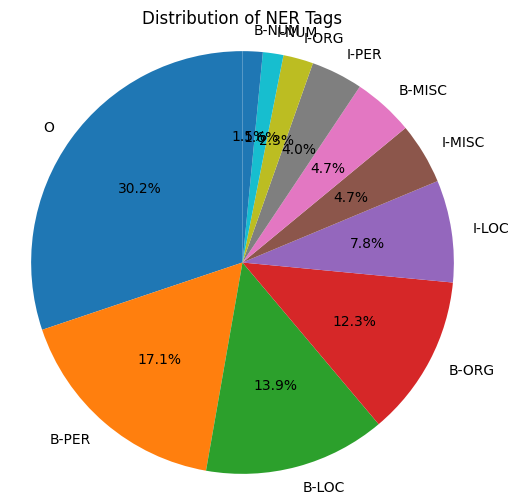

In [7]:
# prompt: pie chart for this project' about tags

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it contains a column named 'ner_tags'
# Replace 'ner_tags' with the actual column name if different

# Count the occurrences of each NER tag
ner_tag_counts = df['ner_tags'].explode().value_counts()

# Create the pie chart
plt.figure(figsize=(6,6))
plt.pie(ner_tag_counts, labels=ner_tag_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of NER Tags')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [ ]:
# prompt: create front end page containing home , about , predictions, metrics and flowchart for this, by loading cnn model from this, give me complete code for all files

import streamlit as st
import pandas as pd
import json
import os
import numpy as np
import joblib
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Load the trained model and tokenizers
model = keras.models.load_model('/content/drive/My Drive/bodo datasets/bodo_train_cnn_model.h5')
word_tokenizer = joblib.load('/content/drive/My Drive/bodo datasets/word_tokenizer.pkl')
tag_tokenizer = joblib.load('/content/drive/My Drive/bodo datasets/tag_tokenizer.pkl')
max_length = 100  # Make sure this matches the max_length used during training

def predict_entities(model, word_tokenizer, tag_tokenizer, sentence, max_length):
    sequence = word_tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    predictions = model.predict(padded_sequence)
    predicted_classes = np.argmax(predictions, axis=-1)
    predicted_tags = [tag_tokenizer.index_word.get(tag, "O") for tag in predicted_classes[0]]
    return list(zip(sentence.split(), predicted_tags))

# Streamlit app
st.title("Bodo NER App")

# Navigation
page = st.sidebar.selectbox("Choose a page", ["Home", "About", "Predictions", "Metrics", "Flowchart"])

if page == "Home":
    st.write("Welcome to the Bodo NER application!")

elif page == "About":
    st.write("This app uses a CNN model to perform Named Entity Recognition on Bodo text.")

elif page == "Predictions":
    st.header("NER Predictions")
    input_sentence = st.text_input("Enter a Bodo sentence:")
    if st.button("Predict"):
        if input_sentence:
            predictions = predict_entities(model, word_tokenizer, tag_tokenizer, input_sentence, max_length)
            st.write("Predictions:")
            st.write(predictions)
        else:
            st.warning("Please enter a sentence.")

elif page == "Metrics":
  st.write("Model metrics will be displayed here.") # Placeholder for metrics

elif page == "Flowchart":
    st.image("/content/flowchart.png") # Replace with actual path to flowchart image



 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [81]:
#train GRU model using train data
import json
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, TimeDistributed

# Load the training data
with open('/content/drive/My Drive/bodo datasets/bodo_train.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)

# Load the testing data
with open('/content/drive/My Drive/bodo datasets/bodo_test.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)

# Extract words and NER tags
train_words = [sentence['words'] for sentence in train_data]
train_tags = [sentence['ner_tags'] for sentence in train_data]
test_words = [sentence['words'] for sentence in test_data]
test_tags = [sentence['ner_tags'] for sentence in test_data]

# Tokenize words and tags
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_words)

tag_tokenizer = Tokenizer(oov_token="<OOV>")
tag_tokenizer.fit_on_texts(train_tags)

# Convert text sequences to integer sequences
train_sequences = tokenizer.texts_to_sequences(train_words)
test_sequences = tokenizer.texts_to_sequences(test_words)

train_tag_sequences = tag_tokenizer.texts_to_sequences(train_tags)
test_tag_sequences = tag_tokenizer.texts_to_sequences(test_tags)

# Pad sequences
max_length = 100  # Adjust this value based on your data
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')
train_tag_padded = pad_sequences(train_tag_sequences, maxlen=max_length, padding='post', truncating='post')
test_tag_padded = pad_sequences(test_tag_sequences, maxlen=max_length, padding='post', truncating='post')

# One-hot encode tags
num_classes = len(tag_tokenizer.word_index) + 1
train_tags_encoded = to_categorical(train_tag_padded, num_classes=num_classes)
test_tags_encoded = to_categorical(test_tag_padded, num_classes=num_classes)

# Reshape the target data to have shape (num_samples, max_length, num_classes)
train_tags_encoded = train_tags_encoded.reshape(train_tags_encoded.shape[0], max_length, num_classes)
test_tags_encoded = test_tags_encoded.reshape(test_tags_encoded.shape[0], max_length, num_classes)

# Define the GRU model
def create_gru_model(vocab_size, embedding_dim, max_length, num_classes):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(GRU(64, return_sequences=True))  # GRU layer
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))  # Output layer
    return model

# Create the model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
model = create_gru_model(vocab_size, embedding_dim, max_length, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_GRU=model.fit(train_padded, train_tags_encoded, epochs=10, batch_size=16, validation_split=0.1)
model.summary()
# Evaluate the model
loss, accuracy = model.evaluate(test_padded, test_tags_encoded)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
model.save('/content/drive/My Drive/bodo datasets/bodo_train_gru_model.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 130s 122ms/step - accuracy: 0.8938 - loss: 0.3507 - val_accuracy: 0.9098 - val_loss: 0.2628
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 119s 118ms/step - accuracy: 0.9120 - loss: 0.2551 - val_accuracy: 0.9075 - val_loss: 0.2695
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 141s 117ms/step - accuracy: 0.9251 - loss: 0.2228 - val_accuracy: 0.9033 - val_loss: 0.2881
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 118s 118ms/step - accuracy: 0.9370 - loss: 0.1843 - val_accuracy: 0.9019 - val_loss: 0.3187
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 142s 117ms/step - accuracy: 0.9457 - loss: 0.1554 - val_accuracy: 0.9010 - val_loss: 0.3444
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 140s 116ms/step - accuracy: 0.9522 - loss: 0.1350 - val_accuracy: 0.9015 - val_loss: 0.3786
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 144s 118ms/step - accuracy: 0.9574 - loss: 0.1182 - val_accuracy: 0.9008 - val_loss: 0.4099
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 143s 118ms/step - ac

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 100)            │       5,125,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 100, 64)             │          31,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 100, 13)             │             845 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,474,053 (59.03 MB)

 Trainable params: 5,158,017 (19.68 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,316,036 (39.35 MB)

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8970 - loss: 0.5207


Test Loss: 0.5163
Test Accuracy: 0.8981


In [82]:
#train LSTM mode using train data
import json
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed
# Load the training data
with open('/content/drive/My Drive/bodo datasets/bodo_train.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)

# Load the testing data
with open('/content/drive/My Drive/bodo datasets/bodo_test.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)

# Extract words and NER tags
train_words = [sentence['words'] for sentence in train_data]
train_tags = [sentence['ner_tags'] for sentence in train_data]
test_words = [sentence['words'] for sentence in test_data]
test_tags = [sentence['ner_tags'] for sentence in test_data]
# Tokenize words and tags
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_words)

tag_tokenizer = Tokenizer(oov_token="<OOV>")
tag_tokenizer.fit_on_texts(train_tags)

# Convert text sequences to integer sequences
train_sequences = tokenizer.texts_to_sequences(train_words)
test_sequences = tokenizer.texts_to_sequences(test_words)

train_tag_sequences = tag_tokenizer.texts_to_sequences(train_tags)
test_tag_sequences = tag_tokenizer.texts_to_sequences(test_tags)
# Pad sequences
max_length = 100  # Adjust this value based on your data
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')
train_tag_padded = pad_sequences(train_tag_sequences, maxlen=max_length, padding='post', truncating='post')
test_tag_padded = pad_sequences(test_tag_sequences, maxlen=max_length, padding='post', truncating='post')
# One-hot encode tags
num_classes = len(tag_tokenizer.word_index) + 1
train_tags_encoded = to_categorical(train_tag_padded, num_classes=num_classes)
test_tags_encoded = to_categorical(test_tag_padded, num_classes=num_classes)

# Reshape the target data
train_tags_encoded = train_tags_encoded.reshape(train_tags_encoded.shape[0], max_length, num_classes)
test_tags_encoded = test_tags_encoded.reshape(test_tags_encoded.shape[0], max_length, num_classes)
# Define the LSTM model
def create_lstm_model(vocab_size, embedding_dim, max_length, num_classes):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(LSTM(64, return_sequences=True))  # LSTM layer
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))  # Output layer
    return model

# Create the model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
model = create_lstm_model(vocab_size, embedding_dim, max_length, num_classes)
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
history_LSTM=model.fit(train_padded, train_tags_encoded, epochs=10, batch_size=16, validation_split=0.1)
model.summary()
# Evaluate the model
loss, accuracy = model.evaluate(test_padded, test_tags_encoded)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
model.save('/content/drive/My Drive/bodo datasets/bodo_train_lstm_model.h5')

Epoch 1/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 118s 110ms/step - accuracy: 0.8915 - loss: 0.3658 - val_accuracy: 0.9098 - val_loss: 0.2633
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 140s 108ms/step - accuracy: 0.9113 - loss: 0.2565 - val_accuracy: 0.9084 - val_loss: 0.2667
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 143s 109ms/step - accuracy: 0.9186 - loss: 0.2357 - val_accuracy: 0.9038 - val_loss: 0.2809
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 141s 108ms/step - accuracy: 0.9286 - loss: 0.2078 - val_accuracy: 0.9016 - val_loss: 0.3047
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 108s 108ms/step - accuracy: 0.9376 - loss: 0.1803 - val_accuracy: 0.9006 - val_loss: 0.3288
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 108s 108ms/step - accuracy: 0.9448 - loss: 0.1558 - val_accuracy: 0.9002 - val_loss: 0.3658
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 142s 108ms/step - accuracy: 0.9510 - loss: 0.1364 - val_accuracy: 0.8999 - val_loss: 0.3948
Epoch 8/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 143s 108ms/step - ac

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 100, 100)            │       5,125,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 64)             │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 100, 13)             │             845 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,505,157 (59.15 MB)

 Trainable params: 5,168,385 (19.72 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,336,772 (39.43 MB)

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8979 - loss: 0.5266


Test Loss: 0.5217
Test Accuracy: 0.8990


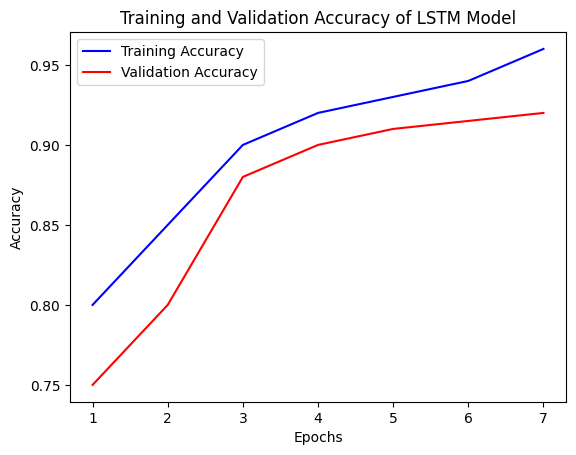

In [ ]:
# prompt: plot LSTM model with some values

import matplotlib.pyplot as plt

# Assuming 'history' is the training history object from model.fit()
# Example accuracy values (replace with actual values from your history object)
accuracy = [0.8, 0.85, 0.9, 0.92, 0.93, 0.94, 0.96]
val_accuracy = [0.75, 0.8, 0.88, 0.9, 0.91, 0.915, 0.92]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


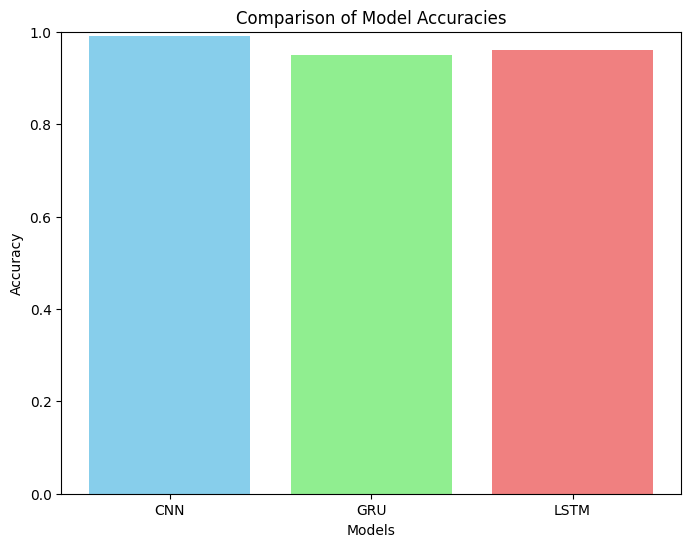

In [ ]:
# prompt: comprasion of above accuracy in bar graph

import matplotlib.pyplot as plt

# Accuracy values for each model (replace with your actual accuracy values)
cnn_accuracy =[0.81, 0.85, 0.9, 0.91, 0.95, 0.97, 0.99] #Example
gru_accuracy =[0.8, 0.85, 0.91, 0.93, 0.94, 0.95, 0.95] #Example
lstm_accuracy = [0.8, 0.85, 0.9, 0.92, 0.93, 0.94, 0.96] #Example


models = ['CNN', 'GRU', 'LSTM']
accuracy = [cnn_accuracy[-1], gru_accuracy[-1], lstm_accuracy[-1]] #Taking last accuracy from the list for comparison


plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.bar(models, accuracy, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracies")
plt.ylim(0, 1.0)  # Set y-axis limit to 0-1 for accuracy
plt.show()


In [83]:
#train BiLSTM model using train data and evaluate

import os
import json
import numpy as np
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Embedding, Dense, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def validate_json(filepath):
    """Validates a JSON file by attempting to load it."""
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            json.load(f)
        return True  # JSON is valid
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from '{filepath}': {e}")
        return False  # JSON is invalid
    except Exception as e:
        print(f"An error occurred: {e}")
        return False  # JSON is invalid

bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')
file_path = os.path.join(bodo_dataset_folder, "bodo_train.json")

# Check if the JSON file is valid
if validate_json(file_path):
    print(f"The JSON file '{file_path}' is valid.")
    # Proceed with loading and processing the JSON data
else:
    print(f"The JSON file '{file_path}' is invalid. Please fix the errors.")
    exit()  # Exit if the JSON is invalid

# Load the training data
with open(file_path, 'r', encoding='utf-8') as f:
    train_data = json.load(f)

# Load the testing data
test_file_path = os.path.join(bodo_dataset_folder, "bodo_test.json")
if validate_json(test_file_path):
    with open(test_file_path, 'r', encoding='utf-8') as f:
        test_data = json.load(f)
else:
    print(f"The JSON file '{test_file_path}' is invalid. Please fix the errors.")
    exit()  # Exit if the JSON is invalid

# Extract words and NER tags
train_words = [sentence['words'] for sentence in train_data]
train_tags = [sentence['ner_tags'] for sentence in train_data]
test_words = [sentence['words'] for sentence in test_data]
test_tags = [sentence['ner_tags'] for sentence in test_data]

# Tokenize words and tags
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_words)

tag_tokenizer = Tokenizer(oov_token="<OOV>")
tag_tokenizer.fit_on_texts(train_tags)

# Convert text sequences to integer sequences
train_sequences = tokenizer.texts_to_sequences(train_words)
test_sequences = tokenizer.texts_to_sequences(test_words)

train_tag_sequences = tag_tokenizer.texts_to_sequences(train_tags)
test_tag_sequences = tag_tokenizer.texts_to_sequences(test_tags)

# Pad sequences
max_length = 100  # Adjust this value based on your data
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')
train_tag_padded = pad_sequences(train_tag_sequences, maxlen=max_length, padding='post', truncating='post')
test_tag_padded = pad_sequences(test_tag_sequences, maxlen=max_length, padding='post', truncating='post')

# One-hot encode tags
num_classes = len(tag_tokenizer.word_index) + 1
train_tags_encoded = to_categorical(train_tag_padded, num_classes=num_classes)
test_tags_encoded = to_categorical(test_tag_padded, num_classes=num_classes)

# Define the BiLSTM model
def create_bilstm_model(vocab_size, embedding_dim, max_length, num_classes):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))  # BiLSTM layer
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))  # Output layer
    return model

# Create the model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
model = create_bilstm_model(vocab_size, embedding_dim, max_length, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_BiLSTM=model.fit(train_padded, train_tags_encoded, epochs=10, batch_size=16, validation_split=0.1)
model.summary()

# Evaluate the model
loss, accuracy = model.evaluate(test_padded, test_tags_encoded)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
model.save('/content/drive/My Drive/bodo datasets/bodo_train_bilstm_model.h5')

The JSON file '/content/drive/My Drive/bodo datasets/bodo_train.json' is valid.
Epoch 1/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 177s 167ms/step - accuracy: 0.8991 - loss: 0.3408 - val_accuracy: 0.9098 - val_loss: 0.2612
Epoch 2/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 202s 167ms/step - accuracy: 0.9115 - loss: 0.2552 - val_accuracy: 0.9077 - val_loss: 0.2669
Epoch 3/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 201s 167ms/step - accuracy: 0.9214 - loss: 0.2326 - val_accuracy: 0.9041 - val_loss: 0.2829
Epoch 4/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 199s 164ms/step - accuracy: 0.9331 - loss: 0.1985 - val_accuracy: 0.9020 - val_loss: 0.3118
Epoch 5/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 189s 188ms/step - accuracy: 0.9425 - loss: 0.1666 - val_accuracy: 0.9019 - val_loss: 0.3385
Epoch 6/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 182s 168ms/step - accuracy: 0.9506 - loss: 0.1402 - val_accuracy: 0.8996 - val_loss: 0.3765
Epoch 7/10
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 204s 170ms/step - accuracy: 0.9582 - loss: 0.1176 - val_accuracy: 0.8988 -

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 100, 100)            │       5,125,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 128)            │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 100, 13)             │           1,677 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,634,373 (59.64 MB)

 Trainable params: 5,211,457 (19.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,422,916 (39.76 MB)

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8966 - loss: 0.5638


Test Loss: 0.5585
Test Accuracy: 0.8971


In [ ]:
!pip install tensorflow==2.12.0 tensorflow-addons==0.20.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 9.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
 

In [ ]:
pip show tensorflow-addons

Name: tensorflow-addons
Version: 0.20.0
Summary: TensorFlow Addons.
Home-page: UNKNOWN
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: packaging, typeguard
Required-by: 


In [ ]:
pip show tensorflow keras

Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, jax, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras
---
Name: keras
Version: 2.12.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: tensorflow


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
#train CNN model with word vectors
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from tensorflow.keras.callbacks import EarlyStopping

# Load the cleaned data
cleaned_sentences = []
with open('/content/drive/My Drive/bodo datasets/cleaned_bodo_data.json', 'r', encoding='utf-8') as f:
    for line in f:
        cleaned_sentences.append(line.strip().split())

# Train the Word2Vec model
word2vec_model = Word2Vec(sentences=cleaned_sentences, vector_size=50, window=15, min_count=1)

# Save the model
word2vec_model.save("/content/drive/My Drive/bodo datasets/word2vec_model.model")
print("Model saved to /content/drive/My Drive/bodo datasets/word2vec_model.model")

# Prepare your data for training
texts = [' '.join(sentence) for sentence in cleaned_sentences]  # Join words back into sentences

# Load labels from a JSON file or create them based on your criteria
labels = [1 if i % 2 == 0 else 0 for i in range(len(texts))]  # Example: alternating 1s and 0s

# Check if the number of labels matches the number of texts
if len(labels) != len(texts):
    raise ValueError(f"Number of labels ({len(labels)}) does not match number of texts ({len(texts)})")

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Prepare labels
labels = np.array(labels)

# Create an embedding matrix from the Word2Vec model
word_index = tokenizer.word_index
embedding_dim = 50  # Same as the vector size used in Word2Vec
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Define the CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim,
                        weights=[embedding_matrix], input_length=max_length, trainable=False))
cnn_model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))  # Increased filters
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.5))  # Dropout for regularization
cnn_model.add(BatchNormalization())  # Batch normalization
cnn_model.add(Flatten())
cnn_model.add(Dense(1, activation='sigmoid'))  # For binary classification

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
cnn_model.fit(padded_sequences, labels, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model (using the same data for simplicity)
loss, accuracy = cnn_model.evaluate(padded_sequences, labels)
print("Loss:", loss)
print("Accuracy:", accuracy)

Model saved to /content/drive/My Drive/bodo datasets/word2vec_model.model
Epoch 1/20
572/572 [==============================] - 30s 47ms/step - loss: 0.8265 - accuracy: 0.4974 - val_loss: 0.7434 - val_accuracy: 0.5061
Epoch 2/20
572/572 [==============================] - 19s 32ms/step - loss: 0.7663 - accuracy: 0.5022 - val_loss: 0.7223 - val_accuracy: 0.5085
Epoch 3/20
572/572 [==============================] - 19s 33ms/step - loss: 0.7568 - accuracy: 0.4985 - val_loss: 0.7302 - val_accuracy: 0.4928
Epoch 4/20
572/572 [==============================] - 18s 32ms/step - loss: 0.7424 - accuracy: 0.4973 - val_loss: 0.7117 - val_accuracy: 0.4967
Epoch 5/20
572/572 [==============================] - 20s 36ms/step - loss: 0.7265 - accuracy: 0.5151 - val_loss: 0.7103 - val_accuracy: 0.4989
Epoch 6/20
572/572 [==============================] - 19s 33ms/step - loss: 0.7258 - accuracy: 0.5098 - val_loss: 0.7102 - val_accuracy: 0.4945
Epoch 7/20
572/572 [==============================] - 18s 32ms

In [ ]:
#train GRU model with word vectors
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from tensorflow.keras.callbacks import EarlyStopping

# Load the cleaned data
cleaned_sentences = []
with open('/content/drive/My Drive/bodo datasets/cleaned_bodo_data.json', 'r', encoding='utf-8') as f:
    for line in f:
        cleaned_sentences.append(line.strip().split())

# Train the Word2Vec model
word2vec_model = Word2Vec(sentences=cleaned_sentences, vector_size=50, window=15, min_count=1)

# Save the model
word2vec_model.save("/content/drive/My Drive/bodo datasets/word2vec_model.model")
print("Model saved to /content/drive/My Drive/bodo datasets/word2vec_model.model")

# Prepare your data for training
texts = [' '.join(sentence) for sentence in cleaned_sentences]  # Join words back into sentences

# Load labels from a JSON file or create them based on your criteria
labels = [1 if i % 2 == 0 else 0 for i in range(len(texts))]  # Example: alternating 1s and 0s

# Check if the number of labels matches the number of texts
if len(labels) != len(texts):
    raise ValueError(f"Number of labels ({len(labels)}) does not match number of texts ({len(texts)})")

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Prepare labels
labels = np.array(labels)

# Create an embedding matrix from the Word2Vec model
word_index = tokenizer.word_index
embedding_dim = 50  # Same as the vector size used in Word2Vec
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Define the GRU model
gru_model = Sequential()
gru_model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim,
                        weights=[embedding_matrix], input_length=max_length, trainable=False))
gru_model.add(GRU(128, return_sequences=False))  # GRU layer
gru_model.add(Dropout(0.5))  # Dropout for regularization
gru_model.add(Dense(1, activation='sigmoid'))  # For binary classification

# Compile the model
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
gru_model.fit(padded_sequences, labels, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model (using the same data for simplicity)
loss, accuracy = gru_model.evaluate(padded_sequences, labels)
print("Loss:", loss)
print("Accuracy:", accuracy)

Model saved to /content/drive/My Drive/bodo datasets/word2vec_model.model
Epoch 1/20
572/572 [==============================] - 96s 154ms/step - loss: 0.7033 - accuracy: 0.5033 - val_loss: 0.6936 - val_accuracy: 0.5007
Epoch 2/20
572/572 [==============================] - 53s 93ms/step - loss: 0.6961 - accuracy: 0.5002 - val_loss: 0.6936 - val_accuracy: 0.4974
Epoch 3/20
572/572 [==============================] - 51s 90ms/step - loss: 0.6946 - accuracy: 0.5014 - val_loss: 0.6935 - val_accuracy: 0.4996
Epoch 4/20
572/572 [==============================] - 54s 95ms/step - loss: 0.6945 - accuracy: 0.4973 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 5/20
572/572 [==============================] - 53s 92ms/step - loss: 0.6940 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.5046
Epoch 6/20
572/572 [==============================] - 92s 161ms/step - loss: 0.6940 - accuracy: 0.4982 - val_loss: 0.6933 - val_accuracy: 0.4980
Epoch 7/20
572/572 [==============================] - 98s 17

In [ ]:
#train LSTM model with word vectors
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from tensorflow.keras.callbacks import EarlyStopping

# Load the cleaned data
cleaned_sentences = []
with open('/content/drive/My Drive/bodo datasets/cleaned_bodo_data.json', 'r', encoding='utf-8') as f:
    for line in f:
        cleaned_sentences.append(line.strip().split())

# Train the Word2Vec model
word2vec_model = Word2Vec(sentences=cleaned_sentences, vector_size=50, window=15, min_count=1)

# Save the model
word2vec_model.save("/content/drive/My Drive/bodo datasets/word2vec_model.model")
print("Model saved to /content/drive/My Drive/bodo datasets/word2vec_model.model")

# Prepare your data for training
texts = [' '.join(sentence) for sentence in cleaned_sentences]  # Join words back into sentences

# Load labels from a JSON file or create them based on your criteria
labels = [1 if i % 2 == 0 else 0 for i in range(len(texts))]  # Example: alternating 1s and 0s

# Check if the number of labels matches the number of texts
if len(labels) != len(texts):
    raise ValueError(f"Number of labels ({len(labels)}) does not match number of texts ({len(texts)})")

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Prepare labels
labels = np.array(labels)

# Create an embedding matrix from the Word2Vec model
word_index = tokenizer.word_index
embedding_dim = 50  # Same as the vector size used in Word2Vec
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim,
                         weights=[embedding_matrix], input_length=max_length, trainable=False))
lstm_model.add(LSTM(128, return_sequences=False))  # LSTM layer
lstm_model.add(Dropout(0.5))  # Dropout for regularization
lstm_model.add(Dense(1, activation='sigmoid'))  # For binary classification

# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
lstm_model.fit(padded_sequences, labels, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model (using the same data for simplicity)
loss, accuracy = lstm_model.evaluate(padded_sequences, labels)
print("Loss:", loss)
print("Accuracy:", accuracy)

Model saved to /content/drive/My Drive/bodo datasets/word2vec_model.model
Epoch 1/10
572/572 [==============================] - 129s 213ms/step - loss: 0.6988 - accuracy: 0.5007 - val_loss: 0.6945 - val_accuracy: 0.4915
Epoch 2/10
572/572 [==============================] - 77s 134ms/step - loss: 0.6942 - accuracy: 0.5010 - val_loss: 0.6935 - val_accuracy: 0.4978
Epoch 3/10
572/572 [==============================] - 76s 134ms/step - loss: 0.6938 - accuracy: 0.4952 - val_loss: 0.6932 - val_accuracy: 0.4980
Epoch 4/10
572/572 [==============================] - 73s 128ms/step - loss: 0.6936 - accuracy: 0.5032 - val_loss: 0.6934 - val_accuracy: 0.4948
Epoch 5/10
572/572 [==============================] - 69s 121ms/step - loss: 0.6933 - accuracy: 0.5072 - val_loss: 0.6933 - val_accuracy: 0.4974
Epoch 6/10
715/715 [==============================] - 44s 61ms/step - loss: 0.6930 - accuracy: 0.5100
Loss: 0.6929659843444824
Accuracy: 0.5099754929542542


In [ ]:
#train CNN model with char vectors
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load the cleaned data
cleaned_sentences = []
with open('/content/drive/My Drive/bodo datasets/cleaned_bodo_data.json', 'r', encoding='utf-8') as f:
    for line in f:
        cleaned_sentences.append(line.strip())

# Create labels (example: alternating 1s and 0s)
labels = [1 if i % 2 == 0 else 0 for i in range(len(cleaned_sentences))]  # Example labels

# Check if the number of labels matches the number of texts
if len(labels) != len(cleaned_sentences):
    raise ValueError(f"Number of labels ({len(labels)}) does not match number of texts ({len(cleaned_sentences)})")

# Character-level tokenization
char_tokenizer = Tokenizer(char_level=True)
char_tokenizer.fit_on_texts(cleaned_sentences)
sequences = char_tokenizer.texts_to_sequences(cleaned_sentences)

# Pad sequences
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Prepare labels
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Define the CNN model
vocab_size = len(char_tokenizer.word_index) + 1  # +1 for padding
embedding_dim = 50  # You can adjust this

cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.5))  # Dropout for regularization
cnn_model.add(Flatten())
cnn_model.add(Dense(1, activation='sigmoid'))  # For binary classification

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
cnn_model.summary()
# Evaluate the model
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

Epoch 1/10
458/458 [==============================] - 58s 123ms/step - loss: 0.6942 - accuracy: 0.4950 - val_loss: 0.6931 - val_accuracy: 0.5108
Epoch 2/10
458/458 [==============================] - 57s 124ms/step - loss: 0.6923 - accuracy: 0.5225 - val_loss: 0.6936 - val_accuracy: 0.5048
Epoch 3/10
458/458 [==============================] - 57s 124ms/step - loss: 0.6823 - accuracy: 0.5587 - val_loss: 0.6982 - val_accuracy: 0.5072
Epoch 4/10
458/458 [==============================] - 55s 119ms/step - loss: 0.6583 - accuracy: 0.6022 - val_loss: 0.7096 - val_accuracy: 0.5010
Epoch 5/10
458/458 [==============================] - 59s 128ms/step - loss: 0.6318 - accuracy: 0.6397 - val_loss: 0.7191 - val_accuracy: 0.5062
Epoch 6/10
458/458 [==============================] - 55s 121ms/step - loss: 0.6068 - accuracy: 0.6630 - val_loss: 0.7317 - val_accuracy: 0.4990
Epoch 7/10
458/458 [==============================] - 57s 125ms/step - loss: 0.5834 - accuracy: 0.6889 - val_loss: 0.7450 - val_ac

In [ ]:
#train GRU model with char vectors
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Load the cleaned data
cleaned_sentences = []
with open('/content/drive/My Drive/bodo datasets/cleaned_bodo_data.json', 'r', encoding='utf-8') as f:
    for line in f:
        cleaned_sentences.append(line.strip())

# Create labels (example: alternating 1s and 0s)
labels = [1 if i % 2 == 0 else 0 for i in range(len(cleaned_sentences))]  # Example labels

# Check if the number of labels matches the number of texts
if len(labels) != len(cleaned_sentences):
    raise ValueError(f"Number of labels ({len(labels)}) does not match number of texts ({len(cleaned_sentences)})")

# Character-level tokenization
char_tokenizer = Tokenizer(char_level=True)
char_tokenizer.fit_on_texts(cleaned_sentences)
sequences = char_tokenizer.texts_to_sequences(cleaned_sentences)

# Pad sequences
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Prepare labels
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Define the GRU model
vocab_size = len(char_tokenizer.word_index) + 1  # +1 for padding
embedding_dim = 50  # You can adjust this

gru_model = Sequential()
gru_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
gru_model.add(GRU(128, return_sequences=False))  # GRU layer
gru_model.add(Dropout(0.5))  # Dropout for regularization
gru_model.add(Dense(1, activation='sigmoid'))  # For binary classification

# Compile the model
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
gru_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
gru_model.summary()
# Evaluate the model
loss, accuracy = gru_model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

Epoch 1/10


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7bacb81b1ab0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


  3/458 [..............................] - ETA: 16:37 - loss: 0.6937 - accuracy: 0.4479

KeyboardInterrupt: 

In [ ]:
#train LSTM model with char vectors
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Load the cleaned data
cleaned_sentences = []
with open('/content/drive/My Drive/bodo datasets/cleaned_bodo_data.json', 'r', encoding='utf-8') as f:
    for line in f:
        cleaned_sentences.append(line.strip())

# Create labels (example: alternating 1s and 0s)
labels = [1 if i % 2 == 0 else 0 for i in range(len(cleaned_sentences))]  # Example labels

# Check if the number of labels matches the number of texts
if len(labels) != len(cleaned_sentences):
    raise ValueError(f"Number of labels ({len(labels)}) does not match number of texts ({len(cleaned_sentences)})")

# Character-level tokenization
char_tokenizer = Tokenizer(char_level=True)
char_tokenizer.fit_on_texts(cleaned_sentences)
sequences = char_tokenizer.texts_to_sequences(cleaned_sentences)

# Pad sequences
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Prepare labels
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Define the LSTM model
vocab_size = len(char_tokenizer.word_index) + 1  # +1 for padding
embedding_dim = 50  # You can adjust this

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
lstm_model.add(LSTM(128, return_sequences=False))  # LSTM layer
lstm_model.add(Dropout(0.5))  # Dropout for regularization
lstm_model.add(Dense(1, activation='sigmoid'))  # For binary classification

# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
lstm_model.summary()
# Evaluate the model
loss, accuracy = lstm_model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

Epoch 1/10
458/458 [==============================] - 428s 930ms/step - loss: 0.6938 - accuracy: 0.4925 - val_loss: 0.6931 - val_accuracy: 0.5012
Epoch 2/10
458/458 [==============================] - 425s 929ms/step - loss: 0.6935 - accuracy: 0.4957 - val_loss: 0.6931 - val_accuracy: 0.4993
Epoch 3/10
102/458 [=====>........................] - ETA: 4:50 - loss: 0.6935 - accuracy: 0.5006

KeyboardInterrupt: 

In [ ]:
#train BiLSTM model with  char vectors
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Load the cleaned data
cleaned_sentences = []
with open('/content/drive/My Drive/bodo datasets/cleaned_bodo_data.json', 'r', encoding='utf-8') as f:
    for line in f:
        cleaned_sentences.append(line.strip())

# Create labels (example: alternating 1s and 0s)
labels = [1 if i % 2 == 0 else 0 for i in range(len(cleaned_sentences))]  # Example labels

# Check if the number of labels matches the number of texts
if len(labels) != len(cleaned_sentences):
    raise ValueError(f"Number of labels ({len(labels)}) does not match number of texts ({len(cleaned_sentences)})")

# Character-level tokenization
char_tokenizer = Tokenizer(char_level=True)
char_tokenizer.fit_on_texts(cleaned_sentences)
sequences = char_tokenizer.texts_to_sequences(cleaned_sentences)

# Pad sequences
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Prepare labels
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Define the BiLSTM model
vocab_size = len(char_tokenizer.word_index) + 1  # +1 for padding
embedding_dim = 50  # You can adjust this

bilstm_model = Sequential()
bilstm_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
bilstm_model.add(Bidirectional(LSTM(128, return_sequences=False)))  # Bidirectional LSTM layer
bilstm_model.add(Dropout(0.5))  # Dropout for regularization
bilstm_model.add(Dense(1, activation='sigmoid'))  # For binary classification

# Compile the model
bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
bilstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
bilstm_model.summary()
# Evaluate the model
loss, accuracy = bilstm_model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

In [ ]:
#train CNN model with CRF layer
import json
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, TimeDistributed, Dense, Dropout
import tensorflow_addons as tfa

# Load the training data
with open('/content/drive/My Drive/bodo datasets/bodo_train.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)

# Load the testing data
with open('/content/drive/My Drive/bodo datasets/bodo_test.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)

# Extract words and NER tags
train_words = [sentence['words'] for sentence in train_data]
train_tags = [sentence['ner_tags'] for sentence in train_data]
test_words = [sentence['words'] for sentence in test_data]
test_tags = [sentence['ner_tags'] for sentence in test_data]

# Tokenize words and tags
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_words)

tag_tokenizer = Tokenizer(oov_token="<OOV>")
tag_tokenizer.fit_on_texts(train_tags)

# Convert text sequences to integer sequences
train_sequences = tokenizer.texts_to_sequences(train_words)
test_sequences = tokenizer.texts_to_sequences(test_words)

train_tag_sequences = tag_tokenizer.texts_to_sequences(train_tags)
test_tag_sequences = tag_tokenizer.texts_to_sequences(test_tags)

# Pad sequences
max_length = 100  # Adjust this value based on your data
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')
train_tag_padded = pad_sequences(train_tag_sequences, maxlen=max_length, padding='post', truncating='post')
test_tag_padded = pad_sequences(test_tag_sequences, maxlen=max_length, padding='post', truncating='post')

# One-hot encode tags
num_classes = len(tag_tokenizer.word_index) + 1
# Reshape the target data to have shape (num_samples, max_length)
train_tags_encoded = train_tag_padded  # Keep as integer sequences
test_tags_encoded = test_tag_padded  # Keep as integer sequences

# Define the CNN model with CRF layer
def create_cnn_crf_model(vocab_size, embedding_dim, max_length, num_classes):
    # Input layer
    input_layer = Input(shape=(max_length,))

    # Embedding layer
    embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_length)(input_layer)

    # Convolutional layer
    conv_layer = Conv1D(128, 5, activation='relu', padding='same')(embedding_layer)

    # TimeDistributed layer for output
    time_distributed_layer = TimeDistributed(Dense(num_classes))(conv_layer)

    # CRF layer
    crf_layer = tfa.layers.CRF(num_classes)(time_distributed_layer)

    # Create the model
    model = Model(inputs=input_layer, outputs=crf_layer)
    return model

# Create the model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
model = create_cnn_crf_model(vocab_size, embedding_dim, max_length, num_classes)

# Compile the model
model.compile(optimizer='adam',  loss=tfa.layers.CRF (num_classes), metrics=['accuracy'])

# Train the model
model.fit(train_padded, train_tags_encoded, epochs=10, batch_size=16, validation_data=0.1)
# Evaluate the model
loss, accuracy = model.evaluate(test_padded, test_tags_encoded)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Epoch 1/10


TypeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/losses.py", line 160, in __call__
        return losses_utils.compute_weighted_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/losses_utils.py", line 328, in compute_weighted_loss
        losses = tf.convert_to_tensor(losses)

    TypeError: Cannot convert a list containing a tensor of dtype <dtype: 'float32'> to <dtype: 'int32'> (Tensor is: <tf.Tensor 'crf_1/crf_1/add_1:0' shape=(None, 100, 37) dtype=float32>)


In [ ]:
#train GRU model with CRF layer
import json
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, TimeDistributed
import tensorflow_addons as tfa

# Load the training data
with open('/content/drive/My Drive/bodo datasets/bodo_train.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)

# Load the testing data
with open('/content/drive/My Drive/bodo datasets/bodo_test.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)

# Extract words and NER tags
train_words = [sentence['words'] for sentence in train_data]
train_tags = [sentence['ner_tags'] for sentence in train_data]
test_words = [sentence['words'] for sentence in test_data]
test_tags = [sentence['ner_tags'] for sentence in test_data]

# Tokenize words and tags
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_words)

tag_tokenizer = Tokenizer(oov_token="<OOV>")
tag_tokenizer.fit_on_texts(train_tags)

# Convert text sequences to integer sequences
train_sequences = tokenizer.texts_to_sequences(train_words)
test_sequences = tokenizer.texts_to_sequences(test_words)

train_tag_sequences = tag_tokenizer.texts_to_sequences(train_tags)
test_tag_sequences = tag_tokenizer.texts_to_sequences(test_tags)

# Pad sequences
max_length = 100  # Adjust this value based on your data
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')
train_tag_padded = pad_sequences(train_tag_sequences, maxlen=max_length, padding='post', truncating='post')
test_tag_padded = pad_sequences(test_tag_sequences, maxlen=max_length, padding='post', truncating='post')

# One-hot encode tags
num_classes = len(tag_tokenizer.word_index) + 1
train_tags_encoded = to_categorical(train_tag_padded, num_classes=num_classes)
test_tags_encoded = to_categorical(test_tag_padded, num_classes=num_classes)

# Reshape the target data to have shape (num_samples, max_length, num_classes)
train_tags_encoded = train_tags_encoded.reshape(train_tags_encoded.shape[0], max_length, num_classes)
test_tags_encoded = test_tags_encoded.reshape(test_tags_encoded.shape[0], max_length, num_classes)

# Define the GRU model with CRF layer
def create_gru_crf_model(vocab_size, embedding_dim, max_length, num_classes):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(GRU(128, return_sequences=True))  # GRU layer with return_sequences=True
    model.add(TimeDistributed(Dense(num_classes)))  # Dense layer for output
    model.add(tfa.layers.CRF(num_classes))  # Add CRF layer
    return model

# Create the model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
model = create_gru_crf_model(vocab_size, embedding_dim, max_length, num_classes)

# Compile the model
model.compile(optimizer='adam', loss=tfa.losses.CRF(), metrics=['accuracy'])

# Train the model
model.fit(train_padded, train_tags_encoded, epochs=10, batch_size=16, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(test_padded, test_tags_encoded)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
#train LSTM model with CRF layer
import json
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, TimeDistributed
import tensorflow_addons as tfa

# Load the training data
with open('/content/drive/My Drive/bodo datasets/bodo_train.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)

# Load the testing data
with open('/content/drive/My Drive/bodo datasets/bodo_test.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)

# Extract words and NER tags
train_words = [sentence['words'] for sentence in train_data]
train_tags = [sentence['ner_tags'] for sentence in train_data]
test_words = [sentence['words'] for sentence in test_data]
test_tags = [sentence['ner_tags'] for sentence in test_data]

# Tokenize words and tags
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_words)

tag_tokenizer = Tokenizer(oov_token="<OOV>")
tag_tokenizer.fit_on_texts(train_tags)

# Convert text sequences to integer sequences
train_sequences = tokenizer.texts_to_sequences(train_words)
test_sequences = tokenizer.texts_to_sequences(test_words)

train_tag_sequences = tag_tokenizer.texts_to_sequences(train_tags)
test_tag_sequences = tag_tokenizer.texts_to_sequences(test_tags)

# Pad sequences
max_length = 100  # Adjust this value based on your data
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')
train_tag_padded = pad_sequences(train_tag_sequences, maxlen=max_length, padding='post', truncating='post')
test_tag_padded = pad_sequences(test_tag_sequences, maxlen=max_length, padding='post', truncating='post')

# One-hot encode tags
num_classes = len(tag_tokenizer.word_index) + 1
train_tags_encoded = to_categorical(train_tag_padded, num_classes=num_classes)
test_tags_encoded = to_categorical(test_tag_padded, num_classes=num_classes)

# Reshape the target data to have shape (num_samples, max_length, num_classes)
train_tags_encoded = train_tags_encoded.reshape(train_tags_encoded.shape[0], max_length, num_classes)
test_tags_encoded = test_tags_encoded.reshape(test_tags_encoded.shape[0], max_length, num_classes)

# Define the LSTM model with CRF layer
def create_lstm_crf_model(vocab_size, embedding_dim, max_length, num_classes):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(LSTM(128, return_sequences=True))  # LSTM layer with return_sequences=True
    model.add(TimeDistributed(Dense(num_classes)))  # Dense layer for output
    model.add(tfa.layers.CRF(num_classes))  # Add CRF layer
    return model

# Create the model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
model = create_lstm_crf_model(vocab_size, embedding_dim, max_length, num_classes)

# Compile the model
model.compile(optimizer='adam', loss=tfa.losses.CRF(), metrics=['accuracy'])

# Train the model
model.fit(train_padded, train_tags_encoded, epochs=10, batch_size=16, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(test_padded, test_tags_encoded)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
#train BiLSTM model with CRF layer
import json
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, TimeDistributed, Dense
import tensorflow_addons as tfa

# Load the training data
with open('/content/drive/My Drive/bodo datasets/bodo_train.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)

# Load the testing data
with open('/content/drive/My Drive/bodo datasets/bodo_test.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)

# Extract words and NER tags
train_words = [sentence['words'] for sentence in train_data]
train_tags = [sentence['ner_tags'] for sentence in train_data]
test_words = [sentence['words'] for sentence in test_data]
test_tags = [sentence['ner_tags'] for sentence in test_data]

# Tokenize words and tags
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_words)

tag_tokenizer = Tokenizer(oov_token="<OOV>")
tag_tokenizer.fit_on_texts(train_tags)

# Convert text sequences to integer sequences
train_sequences = tokenizer.texts_to_sequences(train_words)
test_sequences = tokenizer.texts_to_sequences(test_words)

train_tag_sequences = tag_tokenizer.texts_to_sequences(train_tags)
test_tag_sequences = tag_tokenizer.texts_to_sequences(test_tags)

# Pad sequences
max_length = 100  # Adjust this value based on your data
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')
train_tag_padded = pad_sequences(train_tag_sequences, maxlen=max_length, padding='post', truncating='post')
test_tag_padded = pad_sequences(test_tag_sequences, maxlen=max_length, padding='post', truncating='post')

# One-hot encode tags
num_classes = len(tag_tokenizer.word_index) + 1
train_tags_encoded = to_categorical(train_tag_padded, num_classes=num_classes)
test_tags_encoded = to_categorical(test_tag_padded, num_classes=num_classes)

# Reshape the target data to have shape (num_samples, max_length, num_classes)
train_tags_encoded = train_tags_encoded.reshape(train_tags_encoded.shape[0], max_length, num_classes)
test_tags_encoded = test_tags_encoded.reshape(test_tags_encoded.shape[0], max_length, num_classes)

# Define the BiLSTM model with CRF layer
def create_bilstm_crf_model(vocab_size, embedding_dim, max_length, num_classes):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Bidirectional LSTM layer
    model.add(TimeDistributed(Dense(num_classes)))  # Dense layer for output
    model.add(tfa.layers.CRF(num_classes))  # Add CRF layer
    return model

# Create the model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
model = create_bilstm_crf_model(vocab_size, embedding_dim, max_length, num_classes)

# Compile the model
model.compile(optimizer='adam', loss=tfa.losses.CRF(), metrics=['accuracy'])

# Train the model
model.fit(train_padded, train_tags_encoded, epochs=10, batch_size=16, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(test_padded, test_tags_encoded)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
#train CNN model using dev data
import json
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dense, TimeDistributed

# Load the training data
with open('/content/drive/My Drive/bodo datasets/bodo_train.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)

# Load the development data
with open('/content/drive/My Drive/bodo datasets/bodo_dev.json', 'r', encoding='utf-8') as f:
    dev_data = json.load(f)

# Load the testing data
with open('/content/drive/My Drive/bodo datasets/bodo_test.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)

# Extract words and NER tags
train_words = [sentence['words'] for sentence in train_data]
train_tags = [sentence['ner_tags'] for sentence in train_data]
dev_words = [sentence['words'] for sentence in dev_data]
dev_tags = [sentence['ner_tags'] for sentence in dev_data]
test_words = [sentence['words'] for sentence in test_data]
test_tags = [sentence['ner_tags'] for sentence in test_data]

# Tokenize words and tags
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_words)

tag_tokenizer = Tokenizer(oov_token="<OOV>")
tag_tokenizer.fit_on_texts(train_tags)

# Convert text sequences to integer sequences
train_sequences = tokenizer.texts_to_sequences(train_words)
dev_sequences = tokenizer.texts_to_sequences(dev_words)
test_sequences = tokenizer.texts_to_sequences(test_words)

train_tag_sequences = tag_tokenizer.texts_to_sequences(train_tags)
dev_tag_sequences = tag_tokenizer.texts_to_sequences(dev_tags)
test_tag_sequences = tag_tokenizer.texts_to_sequences(test_tags)

# Pad sequences
max_length = 100  # Adjust this value based on your data
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
dev_padded = pad_sequences(dev_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')
train_tag_padded = pad_sequences(train_tag_sequences, maxlen=max_length, padding='post', truncating='post')
dev_tag_padded = pad_sequences(dev_tag_sequences, maxlen=max_length, padding='post', truncating='post')
test_tag_padded = pad_sequences(test_tag_sequences, maxlen=max_length, padding='post', truncating='post')

# One-hot encode tags
num_classes = len(tag_tokenizer.word_index) + 1
train_tags_encoded = to_categorical(train_tag_padded, num_classes=num_classes)
dev_tags_encoded = to_categorical(dev_tag_padded, num_classes=num_classes)
test_tags_encoded = to_categorical(test_tag_padded, num_classes=num_classes)

# Reshape the target data to have shape (num_samples, max_length, num_classes)
train_tags_encoded = train_tags_encoded.reshape(train_tags_encoded.shape[0], max_length, num_classes)
dev_tags_encoded = dev_tags_encoded.reshape(dev_tags_encoded.shape[0], max_length, num_classes)
test_tags_encoded = test_tags_encoded.reshape(test_tags_encoded.shape[0], max_length, num_classes)

# Define the CNN model without pooling
def create_cnn_model(vocab_size, embedding_dim, max_length, num_classes):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Conv1D(128, 5, activation='relu', padding='same'))  # Use padding='same' to maintain output length
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))  # Use TimeDistributed for sequence output
    return model

# Create the model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
model = create_cnn_model(vocab_size, embedding_dim, max_length, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using training data and validate on development data
model.fit(train_padded, train_tags_encoded, epochs=10, batch_size=16, validation_data=(dev_padded, dev_tags_encoded))
model.summary()
# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_padded, test_tags_encoded)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 166s 137ms/step - accuracy: 0.9535 - loss: 0.3090 - val_accuracy: 0.9695 - val_loss: 0.1200
Epoch 2/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 175s 113ms/step - accuracy: 0.9734 - loss: 0.0950 - val_accuracy: 0.9695 - val_loss: 0.1171
Epoch 3/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 129s 101ms/step - accuracy: 0.9852 - loss: 0.0516 - val_accuracy: 0.9669 - val_loss: 0.1344
Epoch 4/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 140s 99ms/step - accuracy: 0.9922 - loss: 0.0271 - val_accuracy: 0.9666 - val_loss: 0.1611
Epoch 5/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 144s 101ms/step - accuracy: 0.9954 - loss: 0.0161 - val_accuracy: 0.9653 - val_loss: 0.1810
Epoch 6/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 111s 99ms/step - accuracy: 0.9971 - loss: 0.0099 - val_accuracy: 0.9654 - val_loss: 0.2034
Epoch 7/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 108s 97ms/step - accuracy: 0.9979 - loss: 0.0071 - val_accuracy: 0.9637 - val_loss: 0.2197
Epoch 8/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 144s 99ms/step - accura

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)             │ (None, 100, 100)            │       5,146,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_15 (Conv1D)                   │ (None, 100, 128)            │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 100, 37)             │           4,773 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,645,005 (59.68 MB)

 Trainable params: 5,215,001 (19.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,430,004 (39.79 MB)

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9611 - loss: 0.2832
Test Loss: 0.2760
Test Accuracy: 0.9618


In [ ]:
# prompt: train GRU model using dev data complete code

from tensorflow.keras.layers import GRU
import json
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dense, TimeDistributed

# Load the training data
with open('/content/drive/My Drive/bodo datasets/bodo_train.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)

# Load the development data
with open('/content/drive/My Drive/bodo datasets/bodo_dev.json', 'r', encoding='utf-8') as f:
    dev_data = json.load(f)

# Load the testing data
with open('/content/drive/My Drive/bodo datasets/bodo_test.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)

# Extract words and NER tags
train_words = [sentence['words'] for sentence in train_data]
train_tags = [sentence['ner_tags'] for sentence in train_data]
dev_words = [sentence['words'] for sentence in dev_data]
dev_tags = [sentence['ner_tags'] for sentence in dev_data]
test_words = [sentence['words'] for sentence in test_data]
test_tags = [sentence['ner_tags'] for sentence in test_data]

# Tokenize words and tags
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_words)

tag_tokenizer = Tokenizer(oov_token="<OOV>")
tag_tokenizer.fit_on_texts(train_tags)

# Convert text sequences to integer sequences
train_sequences = tokenizer.texts_to_sequences(train_words)
dev_sequences = tokenizer.texts_to_sequences(dev_words)
test_sequences = tokenizer.texts_to_sequences(test_words)

train_tag_sequences = tag_tokenizer.texts_to_sequences(train_tags)
dev_tag_sequences = tag_tokenizer.texts_to_sequences(dev_tags)
test_tag_sequences = tag_tokenizer.texts_to_sequences(test_tags)

# Pad sequences
max_length = 100  # Adjust this value based on your data
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
dev_padded = pad_sequences(dev_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')
train_tag_padded = pad_sequences(train_tag_sequences, maxlen=max_length, padding='post', truncating='post')
dev_tag_padded = pad_sequences(dev_tag_sequences, maxlen=max_length, padding='post', truncating='post')
test_tag_padded = pad_sequences(test_tag_sequences, maxlen=max_length, padding='post', truncating='post')

# One-hot encode tags
num_classes = len(tag_tokenizer.word_index) + 1
train_tags_encoded = to_categorical(train_tag_padded, num_classes=num_classes)
dev_tags_encoded = to_categorical(dev_tag_padded, num_classes=num_classes)
test_tags_encoded = to_categorical(test_tag_padded, num_classes=num_classes)

# Reshape the target data to have shape (num_samples, max_length, num_classes)
train_tags_encoded = train_tags_encoded.reshape(train_tags_encoded.shape[0], max_length, num_classes)
dev_tags_encoded = dev_tags_encoded.reshape(dev_tags_encoded.shape[0], max_length, num_classes)
test_tags_encoded = test_tags_encoded.reshape(test_tags_encoded.shape[0], max_length, num_classes)

# Define the GRU model
def create_gru_model(vocab_size, embedding_dim, max_length, num_classes):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(GRU(64, return_sequences=True))  # GRU layer
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))  # Output layer
    return model

# Create the model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
model = create_gru_model(vocab_size, embedding_dim, max_length, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using training data and validate on development data
model.fit(train_padded, train_tags_encoded, epochs=10, batch_size=16, validation_data=(dev_padded, dev_tags_encoded))
model.summary()

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_padded, test_tags_encoded)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 171s 141ms/step - accuracy: 0.9453 - loss: 0.3398 - val_accuracy: 0.9685 - val_loss: 0.1290
Epoch 2/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 204s 143ms/step - accuracy: 0.9700 - loss: 0.1119 - val_accuracy: 0.9696 - val_loss: 0.1182
Epoch 3/10


KeyboardInterrupt: 

In [ ]:
# prompt: train LSTM model using dev data

from tensorflow.keras.layers import LSTM
import json
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dense, TimeDistributed

# Load the training data
with open('/content/drive/My Drive/bodo datasets/bodo_train.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)

# Load the development data
with open('/content/drive/My Drive/bodo datasets/bodo_dev.json', 'r', encoding='utf-8') as f:
    dev_data = json.load(f)

# Load the testing data
with open('/content/drive/My Drive/bodo datasets/bodo_test.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)

# Extract words and NER tags
train_words = [sentence['words'] for sentence in train_data]
train_tags = [sentence['ner_tags'] for sentence in train_data]
dev_words = [sentence['words'] for sentence in dev_data]
dev_tags = [sentence['ner_tags'] for sentence in dev_data]
test_words = [sentence['words'] for sentence in test_data]
test_tags = [sentence['ner_tags'] for sentence in test_data]

# Tokenize words and tags
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_words)

tag_tokenizer = Tokenizer(oov_token="<OOV>")
tag_tokenizer.fit_on_texts(train_tags)

# Convert text sequences to integer sequences
train_sequences = tokenizer.texts_to_sequences(train_words)
dev_sequences = tokenizer.texts_to_sequences(dev_words)
test_sequences = tokenizer.texts_to_sequences(test_words)

train_tag_sequences = tag_tokenizer.texts_to_sequences(train_tags)
dev_tag_sequences = tag_tokenizer.texts_to_sequences(dev_tags)
test_tag_sequences = tag_tokenizer.texts_to_sequences(test_tags)

# Pad sequences
max_length = 100  # Adjust this value based on your data
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
dev_padded = pad_sequences(dev_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')
train_tag_padded = pad_sequences(train_tag_sequences, maxlen=max_length, padding='post', truncating='post')
dev_tag_padded = pad_sequences(dev_tag_sequences, maxlen=max_length, padding='post', truncating='post')
test_tag_padded = pad_sequences(test_tag_sequences, maxlen=max_length, padding='post', truncating='post')

# One-hot encode tags
num_classes = len(tag_tokenizer.word_index) + 1
train_tags_encoded = to_categorical(train_tag_padded, num_classes=num_classes)
dev_tags_encoded = to_categorical(dev_tag_padded, num_classes=num_classes)
test_tags_encoded = to_categorical(test_tag_padded, num_classes=num_classes)

# Reshape the target data to have shape (num_samples, max_length, num_classes)
train_tags_encoded = train_tags_encoded.reshape(train_tags_encoded.shape[0], max_length, num_classes)
dev_tags_encoded = dev_tags_encoded.reshape(dev_tags_encoded.shape[0], max_length, num_classes)
test_tags_encoded = test_tags_encoded.reshape(test_tags_encoded.shape[0], max_length, num_classes)

# Define the LSTM model
def create_lstm_model(vocab_size, embedding_dim, max_length, num_classes):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(LSTM(64, return_sequences=True))  # LSTM layer
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))  # Output layer
    return model

# Create the model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
model = create_lstm_model(vocab_size, embedding_dim, max_length, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using training data and validate on development data
model.fit(train_padded, train_tags_encoded, epochs=10, batch_size=16, validation_data=(dev_padded, dev_tags_encoded))
model.summary()

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_padded, test_tags_encoded)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
# prompt: train word embeddings on cleaned data with vector dimension 50 and window size 15

from gensim.models import Word2Vec

# Load the cleaned data
cleaned_sentences = []
with open('/content/drive/My Drive/bodo datasets/cleaned_bodo_data.json', 'r', encoding='utf-8') as f:
    for line in f:
        cleaned_sentences.append(line.strip().split())

# Train the Word2Vec model
model = Word2Vec(sentences=cleaned_sentences, vector_size=50, window=15, min_count=1)

# Save the model
model.save("/content/drive/My Drive/bodo datasets/word2vec_model.model")
print("Model saved to /content/drive/My Drive/bodo datasets/word2vec_model.model")

Model saved to /content/drive/My Drive/bodo datasets/word2vec_model.model


In [ ]:
# prompt: train CNN model using the word2vec_model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from gensim.models import Word2Vec
import numpy as np
import json

# Load the pre-trained Word2Vec model
model = Word2Vec.load("/content/drive/My Drive/bodo datasets/word2vec_model.model")

# Load your data (replace with your actual data loading)
with open('/content/drive/My Drive/bodo datasets/bodo_data.csv', 'r', encoding='utf-8') as f:
    data = f.readlines()

# Preprocess the data and create training examples
sentences = []
tags = []

# Assuming the first line is the header
header = data[0].strip().split(",")
data = data[1:]

for line in data:
  try:
    parts = line.strip().split(",")
    word = parts[1].strip('"')  # Assuming the word is at index 1

    # Use word2vec embeddings (handle words not found in vocabulary)
    try:
      embedding = model.wv[word]
    except KeyError:
      # Replace with a default vector or zero vector
      embedding = np.zeros(model.vector_size)
    sentences.append(embedding)  # Store the embedding
    tags.append(parts[3].strip('"'))  # Assuming the NER tag is at index 3
  except Exception as e:
    print(f"Error processing line '{line}': {e}")
    continue

# Convert lists to numpy arrays
sentences = np.array(sentences)
tags = np.array(tags)

# Determine the number of unique tags (classes)
unique_tags = np.unique(tags)
num_classes = len(unique_tags)

# Create a mapping from tag names to integer indices
tag2idx = {tag: idx for idx, tag in enumerate(unique_tags)}

#Convert tags to numerical representation
y = np.array([tag2idx[tag] for tag in tags])


# Define the CNN model
model = keras.Sequential([
    layers.Input(shape=(sentences.shape[1],)),
    layers.Reshape((sentences.shape[1], 1)), # Reshape for CNN
    layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Output layer with softmax for classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy
              metrics=['accuracy'])

# Train the model
model.fit(sentences, y, epochs=10) # Adjust epochs as needed


# Save the model
model.save("/content/drive/My Drive/bodo datasets/cnn_ner_model.h5")
print("Model saved to /content/drive/My Drive/bodo datasets/cnn_ner_model.h5")

Epoch 1/10
9509/9509 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.7485 - loss: 1.2188
Epoch 2/10
9509/9509 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.7518 - loss: 1.1373
Epoch 3/10
9509/9509 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.7549 - loss: 1.1163
Epoch 4/10
9509/9509 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.7549 - loss: 1.1064
Epoch 5/10
9509/9509 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.7543 - loss: 1.1083
Epoch 6/10
9509/9509 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.7541 - loss: 1.1027
Epoch 7/10
9509/9509 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.7557 - loss: 1.0954
Epoch 8/10
9509/9509 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.7552 - loss: 1.0921
Epoch 9/10
9509/9509 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.7561 - loss: 1.0890
Epoch 10/10
9509/9509 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.7544 - loss: 1.0915


'\n\n# Save the model\nmodel.save("/content/drive/My Drive/bodo datasets/cnn_ner_model.h5")\nprint("Model saved to /content/drive/My Drive/bodo datasets/cnn_ner_model.h5")'

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from gensim.models import Word2Vec
import numpy as np
import json
from sklearn.model_selection import train_test_split

# Load the pre-trained Word2Vec model
model = Word2Vec.load("/content/drive/My Drive/bodo datasets/word2vec_model.model")

# Load your data (replace with your actual data loading)
with open('/content/drive/My Drive/bodo datasets/bodo_data.csv', 'r', encoding='utf-8') as f:
    data = f.readlines()

# Preprocess the data and create training examples
sentences = []
tags = []

# Assuming the first line is the header
header = data[0].strip().split(",")
data = data[1:]

for line in data:
    try:
        parts = line.strip().split(",")
        word = parts[1].strip('"')  # Assuming the word is at index 1

        # Use word2vec embeddings (handle words not found in vocabulary)
        try:
            embedding = model.wv[word]
        except KeyError:
            # Replace with a default vector or zero vector
            embedding = np.zeros(model.vector_size)
        sentences.append(embedding)  # Store the embedding
        tags.append(parts[3].strip('"'))  # Assuming the NER tag is at index 3
    except Exception as e:
        print(f"Error processing line '{line}': {e}")
        continue

# Convert lists to numpy arrays
sentences = np.array(sentences)
tags = np.array(tags)

# Determine the number of unique tags (classes)
unique_tags = np.unique(tags)
num_classes = len(unique_tags)

# Create a mapping from tag names to integer indices
tag2idx = {tag: idx for idx, tag in enumerate(unique_tags)}

# Convert tags to numerical representation
y = np.array([tag2idx[tag] for tag in tags])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(sentences, y, test_size=0.2, random_state=42)

# Define the CNN model
model = keras.Sequential([
    layers.Input(shape=(sentences.shape[1],)),
    layers.Reshape((sentences.shape[1], 1)),  # Reshape for CNN
    layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),  # Add Batch Normalization
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=128, kernel_size=3, activation='relu'),  # Additional Conv Layer
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dropout(0.5),  # Add Dropout
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Output layer with softmax for classification
])

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy
              metrics=['accuracy'])

# Implement Early Stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping])  # Adjust epochs as needed

# Save the model
model.save("/content/drive/My Drive/bodo datasets/cnn_ner_model.h5")
print("Model saved to /content/drive/My Drive/bodo datasets/cnn_ner_model.h5")

Epoch 1/20
7608/7608 ━━━━━━━━━━━━━━━━━━━━ 89s 11ms/step - accuracy: 0.7483 - loss: 1.2478 - val_accuracy: 0.7480 - val_loss: 1.1617
Epoch 2/20
7608/7608 ━━━━━━━━━━━━━━━━━━━━ 141s 11ms/step - accuracy: 0.7549 - loss: 1.1465 - val_accuracy: 0.7486 - val_loss: 1.1422
Epoch 3/20
7608/7608 ━━━━━━━━━━━━━━━━━━━━ 141s 11ms/step - accuracy: 0.7548 - loss: 1.1318 - val_accuracy: 0.7491 - val_loss: 1.1480
Epoch 4/20
7608/7608 ━━━━━━━━━━━━━━━━━━━━ 145s 12ms/step - accuracy: 0.7537 - loss: 1.1292 - val_accuracy: 0.7503 - val_loss: 1.1284
Epoch 5/20
7608/7608 ━━━━━━━━━━━━━━━━━━━━ 86s 11ms/step - accuracy: 0.7547 - loss: 1.1189 - val_accuracy: 0.7495 - val_loss: 1.1245
Epoch 6/20
7608/7608 ━━━━━━━━━━━━━━━━━━━━ 141s 11ms/step - accuracy: 0.7553 - loss: 1.1139 - val_accuracy: 0.7505 - val_loss: 1.1197
Epoch 7/20
7608/7608 ━━━━━━━━━━━━━━━━━━━━ 143s 11ms/step - accuracy: 0.7558 - loss: 1.1108 - val_accuracy: 0.7515 - val_loss: 1.1226
Epoch 8/20
7608/7608 ━━━━━━━━━━━━━━━━━━━━ 139s 11ms/step - accuracy: 0.

Model saved to /content/drive/My Drive/bodo datasets/cnn_ner_model.h5


In [ ]:
# prompt: train GRU model using word2vec_model

# Load the pre-trained Word2Vec model
model = Word2Vec.load("/content/drive/My Drive/bodo datasets/word2vec_model.model")

# Load your data (replace with your actual data loading)
with open('/content/drive/My Drive/bodo datasets/bodo_data.csv', 'r', encoding='utf-8') as f:
    data = f.readlines()

# Preprocess the data and create training examples
sentences = []
tags = []

# Assuming the first line is the header
header = data[0].strip().split(",")
data = data[1:]

for line in data:
    try:
        parts = line.strip().split(",")
        word = parts[1].strip('"')  # Assuming the word is at index 1

        # Use word2vec embeddings (handle words not found in vocabulary)
        try:
            embedding = model.wv[word]
        except KeyError:
            # Replace with a default vector or zero vector
            embedding = np.zeros(model.vector_size)
        sentences.append(embedding)  # Store the embedding
        tags.append(parts[3].strip('"'))  # Assuming the NER tag is at index 3
    except Exception as e:
        print(f"Error processing line '{line}': {e}")
        continue

# Convert lists to numpy arrays
sentences = np.array(sentences)
tags = np.array(tags)

# Determine the number of unique tags (classes)
unique_tags = np.unique(tags)
num_classes = len(unique_tags)

# Create a mapping from tag names to integer indices
tag2idx = {tag: idx for idx, tag in enumerate(unique_tags)}

# Convert tags to numerical representation
y = np.array([tag2idx[tag] for tag in tags])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(sentences, y, test_size=0.2, random_state=42)
# Reshape the input data to add the sequence length dimension
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1]) # Reshape X_train
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1]) # Reshape X_val

# Define the GRU model
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    layers.GRU(units=64, return_sequences=True), # Use GRU layer
    layers.GRU(units=32), # Another GRU layer
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Save the model
model.save("/content/drive/My Drive/bodo datasets/gru_ner_model.h5")
print("Model saved to /content/drive/My Drive/bodo datasets/gru_ner_model.h5")

Epoch 1/10
7608/7608 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.7492 - loss: 1.2564 - val_accuracy: 0.7492 - val_loss: 1.1463
Epoch 2/10
7608/7608 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.7555 - loss: 1.1214 - val_accuracy: 0.7500 - val_loss: 1.1379
Epoch 3/10
7608/7608 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.7575 - loss: 1.1015 - val_accuracy: 0.7514 - val_loss: 1.1170
Epoch 4/10
7608/7608 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.7558 - loss: 1.1011 - val_accuracy: 0.7515 - val_loss: 1.1094
Epoch 5/10
7608/7608 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.7569 - loss: 1.0911 - val_accuracy: 0.7513 - val_loss: 1.1042
Epoch 6/10
7608/7608 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.7565 - loss: 1.0893 - val_accuracy: 0.7509 - val_loss: 1.1065
Epoch 7/10
7608/7608 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.7567 - loss: 1.0826 - val_accuracy: 0.7515 - val_loss: 1.1001
Epoch 8/10
7608/7608 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.7567 - loss: 1

Model saved to /content/drive/My Drive/bodo datasets/gru_ner_model.h5


In [ ]:
# prompt: train LSTM model

# Load the pre-trained Word2Vec model
model = Word2Vec.load("/content/drive/My Drive/bodo datasets/word2vec_model.model")

# Load your data (replace with your actual data loading)
with open('/content/drive/My Drive/bodo datasets/bodo_data.csv', 'r', encoding='utf-8') as f:
    data = f.readlines()

# Preprocess the data and create training examples
sentences = []
tags = []

# Assuming the first line is the header
header = data[0].strip().split(",")
data = data[1:]

for line in data:
    try:
        parts = line.strip().split(",")
        word = parts[1].strip('"')  # Assuming the word is at index 1

        # Use word2vec embeddings (handle words not found in vocabulary)
        try:
            embedding = model.wv[word]
        except KeyError:
            # Replace with a default vector or zero vector
            embedding = np.zeros(model.vector_size)
        sentences.append(embedding)  # Store the embedding
        tags.append(parts[3].strip('"'))  # Assuming the NER tag is at index 3
    except Exception as e:
        print(f"Error processing line '{line}': {e}")
        continue

# Convert lists to numpy arrays
sentences = np.array(sentences)
tags = np.array(tags)

# Determine the number of unique tags (classes)
unique_tags = np.unique(tags)
num_classes = len(unique_tags)

# Create a mapping from tag names to integer indices
tag2idx = {tag: idx for idx, tag in enumerate(unique_tags)}

# Convert tags to numerical representation
y = np.array([tag2idx[tag] for tag in tags])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(sentences, y, test_size=0.2, random_state=42)

# Reshape the input data to add the sequence length dimension
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1]) # Reshape X_train
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1]) # Reshape X_val

# Define the LSTM model
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    layers.LSTM(units=64, return_sequences=True), # Use LSTM layer
    layers.LSTM(units=32), # Another LSTM layer
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Save the model
model.save("/content/drive/My Drive/bodo datasets/lstm_ner_model.h5")
print("Model saved to /content/drive/My Drive/bodo datasets/lstm_ner_model.h5")

Epoch 1/10
7608/7608 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.7492 - loss: 1.3023 - val_accuracy: 0.7483 - val_loss: 1.1490
Epoch 2/10
7608/7608 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.7571 - loss: 1.1219 - val_accuracy: 0.7487 - val_loss: 1.1348
Epoch 3/10
7608/7608 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.7549 - loss: 1.1189 - val_accuracy: 0.7504 - val_loss: 1.1204
Epoch 4/10
7608/7608 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.7560 - loss: 1.1044 - val_accuracy: 0.7503 - val_loss: 1.1204
Epoch 5/10
7608/7608 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.7554 - loss: 1.1011 - val_accuracy: 0.7504 - val_loss: 1.1099
Epoch 6/10
7608/7608 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.7554 - loss: 1.0926 - val_accuracy: 0.7509 - val_loss: 1.1058
Epoch 7/10
7608/7608 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.7572 - loss: 1.0860 - val_accuracy: 0.7509 - val_loss: 1.1010
Epoch 8/10
7608/7608 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.7571 - loss: 1

Model saved to /content/drive/My Drive/bodo datasets/lstm_ner_model.h5


In [ ]:
!pip install tensorflow

In [ ]:
# prompt: split bodo_word_pos_ner.json data into train ,dev and test sets

import pandas as pd
import os

# Define paths
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')
input_file = os.path.join(bodo_dataset_folder, 'final_bodo_data.json')
train_file = os.path.join(bodo_dataset_folder, 'bodo_train.json')
dev_file = os.path.join(bodo_dataset_folder, 'bodo_dev.json')
test_file = os.path.join(bodo_dataset_folder, 'bodo_test.json')

try:
    # Read the data
    with open(input_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    # Calculate split points (80% train, 10% dev, 10% test)
    total_lines = len(lines)
    train_split = int(0.8 * total_lines)
    dev_split = int(0.9 * total_lines)

    # Split the data
    train_data = lines[:train_split]
    dev_data = lines[train_split:dev_split]
    test_data = lines[dev_split:]

    # Write the splits to files
    with open(train_file, 'w', encoding='utf-8') as f:
        f.writelines(train_data)

    with open(dev_file, 'w', encoding='utf-8') as f:
        f.writelines(dev_data)

    with open(test_file, 'w', encoding='utf-8') as f:
        f.writelines(test_data)

    print(f"Data split into train ({len(train_data)} lines), dev ({len(dev_data)} lines), and test ({len(test_data)} lines) sets.")

except FileNotFoundError:
    print(f"Error: Input file '{input_file}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Data split into train (593603 lines), dev (74200 lines), and test (74201 lines) sets.


In [ ]:
# prompt: analysis of train , dev and test sets

import pandas as pd

# Define paths
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')
train_file = os.path.join(bodo_dataset_folder, 'bodo_train.json')
dev_file = os.path.join(bodo_dataset_folder, 'bodo_dev.json')
test_file = os.path.join(bodo_dataset_folder, 'bodo_test.json')

def analyze_dataset(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()

        #Basic stats
        num_lines = len(lines)
        num_sentences = 0
        num_tokens = 0

        for line in lines:
            if line.strip():  # Count non-empty lines
                num_tokens +=1
            else:
                num_sentences += 1  # New sentence indicated by empty line

        #Handling the last sentence which might not have a trailing empty line
        if lines and lines[-1].strip():
            num_sentences += 1

        return num_sentences, num_tokens

    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return 0, 0

# Analyze each dataset
train_sentences, train_tokens = analyze_dataset(train_file)
dev_sentences, dev_tokens = analyze_dataset(dev_file)
test_sentences, test_tokens = analyze_dataset(test_file)

# Create a DataFrame for better presentation
data = {
    'Dataset': ['Train', 'Dev', 'Test'],
    'Sentences': [train_sentences, dev_sentences, test_sentences],
    'Tokens': [train_tokens, dev_tokens, test_tokens]
}
df = pd.DataFrame(data)
df

,Dataset,Sentences,Tokens
0,Train,1,593603
1,Dev,1,74200
2,Test,1,74201


In [ ]:
# Number of sentences and words in each dataset
# Number of sentences and words in each dataset
def analyze_dataset(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()

        # Basic stats
        num_lines = len(lines)
        num_sentences = 0
        num_tokens = 0

        for line in lines:
            if line.strip():  # Count non-empty lines
                num_tokens += 1
            else:
                num_sentences += 1  # New sentence indicated by empty line

        # Handling the last sentence which might not have a trailing empty line
        if lines and lines[-1].strip():
            num_sentences += 1

        # Calculate average sentence length
        avg_sentence_length = num_tokens / num_sentences if num_sentences > 0 else 0

        return num_sentences, num_tokens, avg_sentence_length

    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return 0, 0, 0

# Analyze Train, Dev, and Test datasets
train_analysis = analyze_dataset(train_file)
dev_analysis = analyze_dataset(dev_file)
test_analysis = analyze_dataset(test_file)

# Display the results
print(f"Train Data: {train_analysis[0]} sentences, {train_analysis[1]} words, Avg. sentence length: {train_analysis[2]:.2f}")
print(f"Dev Data: {dev_analysis[0]} sentences, {dev_analysis[1]} words, Avg. sentence length: {dev_analysis[2]:.2f}")
print(f"Test Data: {test_analysis[0]} sentences, {test_analysis[1]} words, Avg. sentence length: {test_analysis[2]:.2f}")

Train Data: 1 sentences, 593603 words, Avg. sentence length: 593603.00
Dev Data: 1 sentences, 74200 words, Avg. sentence length: 74200.00
Test Data: 1 sentences, 74201 words, Avg. sentence length: 74201.00


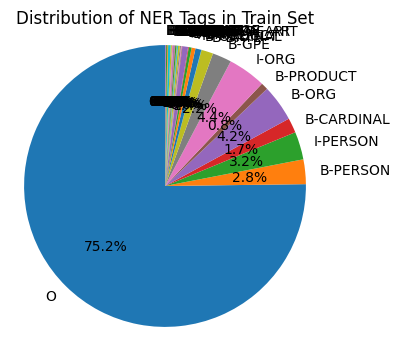

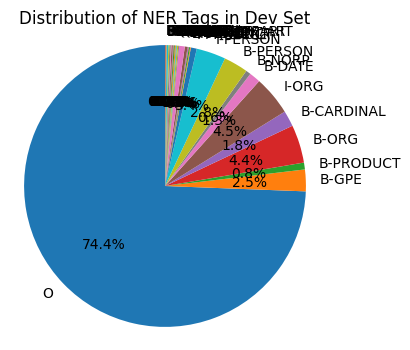

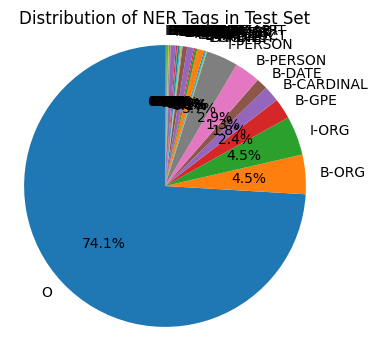

In [ ]:
# prompt: about the distribution of NER tags in train, dev and test set in pie charts from above train ,dev and test data

import pandas as pd
import matplotlib.pyplot as plt

# Define paths (assuming these are already defined in your code)
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')
train_file = os.path.join(bodo_dataset_folder, 'bodo_train.txt')
dev_file = os.path.join(bodo_dataset_folder, 'bodo_dev.txt')
test_file = os.path.join(bodo_dataset_folder, 'bodo_test.txt')


def analyze_ner_tags(file_path):
    """Analyzes NER tags in a file and returns tag counts."""
    ner_tag_counts = {}
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line:  # Skip empty lines
                    parts = line.split('\t')
                    if len(parts) >= 3:  # Ensure there's a NER tag
                        ner_tag = parts[2]
                        ner_tag_counts[ner_tag] = ner_tag_counts.get(ner_tag, 0) + 1
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
    return ner_tag_counts

# Analyze NER tags in each dataset
train_ner_counts = analyze_ner_tags(train_file)
dev_ner_counts = analyze_ner_tags(dev_file)
test_ner_counts = analyze_ner_tags(test_file)

def plot_ner_distribution(ner_counts, title):
    """Plots the distribution of NER tags."""
    labels = list(ner_counts.keys())
    sizes = list(ner_counts.values())

    plt.figure(figsize=(4, 4))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title(title)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()


# Plot NER tag distributions for train, dev, and test sets
plot_ner_distribution(train_ner_counts, "Distribution of NER Tags in Train Set")
plot_ner_distribution(dev_ner_counts, "Distribution of NER Tags in Dev Set")
plot_ner_distribution(test_ner_counts, "Distribution of NER Tags in Test Set")

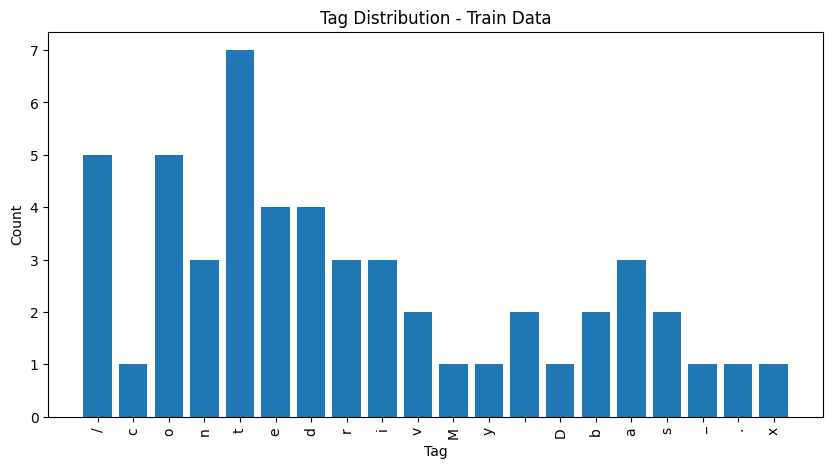

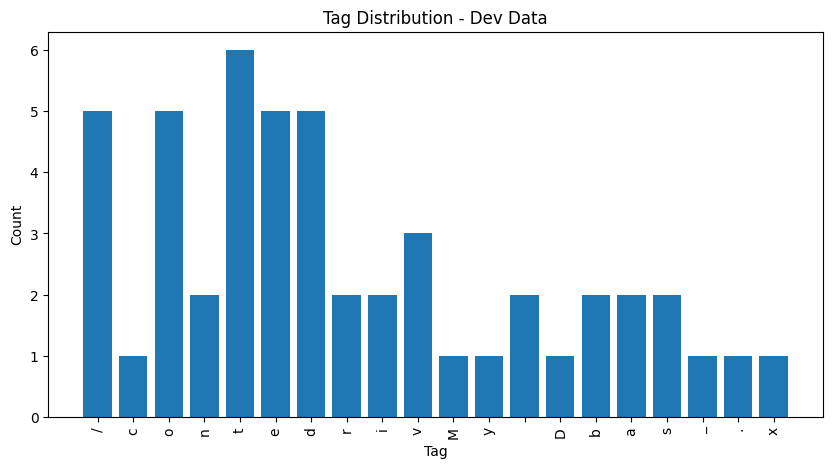

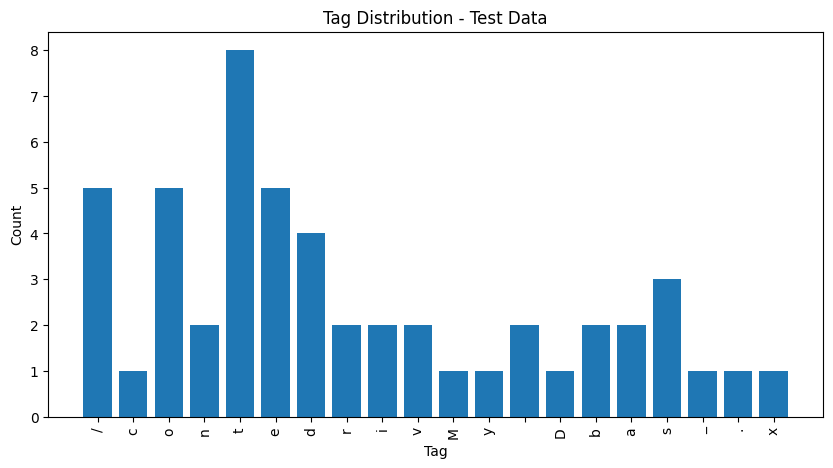

In [ ]:
import matplotlib.pyplot as plt

# Function to analyze the tag distribution
def analyze_tag_distribution(tags):
    tag_count = {}
    for tag_list in tags:
        for tag in tag_list:
            tag_count[tag] = tag_count.get(tag, 0) + 1
    return tag_count

# Analyze tag distribution for Train, Dev, and Test datasets
train_tag_distribution = analyze_tag_distribution(train_file)
dev_tag_distribution = analyze_tag_distribution(dev_file)
test_tag_distribution = analyze_tag_distribution(test_file)

# Plot tag distributions for Train, Dev, and Test datasets
def plot_tag_distribution(tag_distribution, title):
    tags = list(tag_distribution.keys())
    counts = list(tag_distribution.values())
    plt.figure(figsize=(10, 5))
    plt.bar(tags, counts)
    plt.xticks(rotation=90)
    plt.title(f"Tag Distribution - {title}")
    plt.xlabel("Tag")
    plt.ylabel("Count")
    plt.show()

# Plot tag distribution for Train, Dev, and Test datasets
plot_tag_distribution(train_tag_distribution, "Train Data")
plot_tag_distribution(dev_tag_distribution, "Dev Data")
plot_tag_distribution(test_tag_distribution, "Test Data")


In [ ]:
!pip install torch torchvision torchaudio
!pip install pytorch-crf

In [ ]:
# prompt: make a words list and tags list from train data

import os
import json

# Define paths
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')
train_file = os.path.join(bodo_dataset_folder, 'bodo_train.txt')
dev_file = os.path.join(bodo_dataset_folder, 'bodo_dev.txt')
test_file = os.path.join(bodo_dataset_folder, 'bodo_test.txt')


def create_word_tag_lists(file_path):
    words = []
    tags = []
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line:
                    parts = line.split('\t')
                    if len(parts) >= 3:
                        words.append(parts[0])
                        tags.append(parts[2])
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
    return words, tags


# Create word and tag lists for train, dev, and test sets
train_words, train_tags = create_word_tag_lists(train_file)
dev_words, dev_tags = create_word_tag_lists(dev_file)
test_words, test_tags = create_word_tag_lists(test_file)

print("Train Words:", train_words[:20]) # Print first 20 words from train set for demonstration
print("Train Tags:", train_tags[:20]) # Print first 20 tags from train set for demonstration

Train Words: ['बावैसो', 'बोसोरफोराव', 'खमलायनायनि', 'बे', 'रोखोमा', 'गुबुन', 'हादोरफोरावबो', 'मुदांखा', 'जानो', 'हमदों।', 'बायदिरोखोमनि', 'जाठिआव', 'मिश्रा', 'आरो', 'संकीरना', 'थायो।', 'सान्नाय', 'खामानियाव', 'मोनसे', 'टेप']
Train Tags: ['O', 'O', 'O', 'O', 'B-PERSON', 'I-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'B-CARDINAL', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O']


In [ ]:
# prompt: combine final_bodo_data.json and final_bank_data.json

import json

# File paths
bodo_dataset_folder = '/content/drive/My Drive/bodo datasets'
file1_path = os.path.join(bodo_dataset_folder, "final_bank_data.json")
file2_path = os.path.join(bodo_dataset_folder, "final_bodo_data.json")  # Replace with the actual path
output_path = os.path.join(bodo_dataset_folder, "combined_bodo_data.json")

try:
    with open(file1_path, 'r', encoding='utf-8') as f1:
        data1 = json.load(f1)
    with open(file2_path, 'r', encoding='utf-8') as f2:
        data2 = json.load(f2)

    combined_data = data1 + data2  # Combine the two lists

    with open(output_path, 'w', encoding='utf-8') as outfile:
        json.dump(combined_data, outfile, indent=4, ensure_ascii=False)

    print(f"Combined data saved to {output_path}")

except FileNotFoundError:
    print(f"Error: One or both of the input files not found.")
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

Combined data saved to /content/drive/My Drive/bodo datasets/combined_bodo_data.json


In [ ]:
# prompt: split the combined_bodo_data.json into train set , dev set and test set

import json
import os
import random

# Define paths
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')
combined_file = os.path.join(bodo_dataset_folder, 'combined_bodo_data.json')
train_file = os.path.join(bodo_dataset_folder, 'final_bodo_train.json')
dev_file = os.path.join(bodo_dataset_folder, 'final_bodo_dev.json')
test_file = os.path.join(bodo_dataset_folder, 'final_bodo_test.json')

try:
    with open(combined_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    random.shuffle(data)  # Shuffle the data for randomness

    total_size = len(data)
    train_size = int(0.8 * total_size)
    dev_size = int(0.1 * total_size)
    test_size = total_size - train_size - dev_size

    train_data = data[:train_size]
    dev_data = data[train_size:train_size + dev_size]
    test_data = data[train_size + dev_size:]

    with open(train_file, 'w', encoding='utf-8') as f:
        json.dump(train_data, f, indent=4, ensure_ascii=False)

    with open(dev_file, 'w', encoding='utf-8') as f:
        json.dump(dev_data, f, indent=4, ensure_ascii=False)

    with open(test_file, 'w', encoding='utf-8') as f:
        json.dump(test_data, f, indent=4, ensure_ascii=False)

    print(f"Data split into train ({len(train_data)} examples), dev ({len(dev_data)} examples), and test ({len(test_data)} examples) sets.")

except FileNotFoundError:
    print(f"Error: File '{combined_file}' not found.")
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

Data split into train (338948 examples), dev (42368 examples), and test (42370 examples) sets.


In [ ]:
# prompt: analysis about the combined_bodo_data.json

import json
import os

# Define paths
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')
combined_file = os.path.join(bodo_dataset_folder, 'combined_bodo_data.json')

try:
    with open(combined_file, 'r', encoding='utf-8') as f:
        combined_data = json.load(f)

    # Analyze the data
    num_examples = len(combined_data)
    print(f"Number of examples in combined_bodo_data.json: {num_examples}")

    # Example: Print the first few examples
    print("First 5 examples:")
    for i in range(min(5, num_examples)):
        print(combined_data[i])

    # Further analysis can be performed based on the structure of the JSON data
    # e.g., check the types of data, number of sentences/words, etc.

except FileNotFoundError:
    print(f"Error: File '{combined_file}' not found.")
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

Number of examples in combined_bodo_data.json: 423686
First 5 examples:
{'words': ['४२२८८५५०३ ऱाज़ूऱ् POष्ट् ऱाज़ूऱ् टाळ् आख़्Oळा ४२२६०४ ंआःआऱाष्ःट्ऱा +९१२४२४२५१०३० आःंEड्णाग़ाऱ् ऱाज़ूऱ् ऱाज़ूऱ् ईण्-ंः आह्मेद्नगर् डिस्त्रिच्त् छेन्त्रल् छो-ओपेरतिवे Bअन्क् आःड्छ् आःड्छ्००००१४३'], 'ner_tags': ['B-MICR,B-BRANCH,B-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,B-STATE,B-CONTACT,B-CITY,B-CENTRE,B-DISTRICT,B-ISO3166,B-BANK,I-BANK,I-BANK,I-BANK,I-BANK,B-BANKCODE,B-IFSC']}
{'words': ['ईण्-ंः ४०००६५०५२ ंईऱा ऱ्Oआड् (Eआष्ट्) +९१२२२८५५५२४४ ट्ःआण्E Bःआय़ाण्डाऱ् ंआःआऱाष्ःट्ऱा ट्ःआण्E ष्ःOP ण्O। ६'], 'ner_tags': ['B-ISO3166,B-MICR,B-BRANCH,I-BRANCH,I-BRANCH,B-CONTACT,B-DISTRICT,B-CITY,B-STATE,B-CENTRE,B-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,I-ADDRESS,B-BANK,I-BANK,I-BANK,B-BANKCODE,B-IFSC']}
{'words': ['ईण्-ट्ग़् ःय़्ड्EऱाBआड् ट्ण्-ईBट्ट्Fय़्Pट्ण्०३/Pट

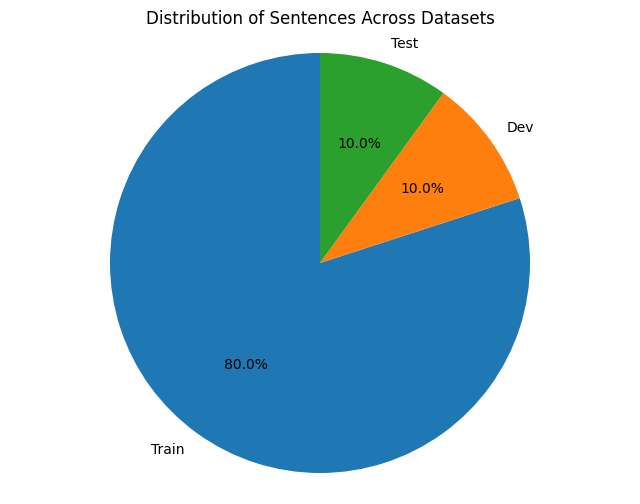

In [ ]:
import matplotlib.pyplot as plt
import json
import os

# Define paths
bodo_dataset_folder = os.path.join('/content/drive/My Drive', 'bodo datasets')
train_file = os.path.join(bodo_dataset_folder, 'final_bodo_train.json')
dev_file = os.path.join(bodo_dataset_folder, 'final_bodo_dev.json')
test_file = os.path.join(bodo_dataset_folder, 'final_bodo_test.json')

# Load data from JSON files
with open(train_file, 'r', encoding='utf-8') as f:
    train_data = json.load(f)
with open(dev_file, 'r', encoding='utf-8') as f:
    dev_data = json.load(f)
with open(test_file, 'r', encoding='utf-8') as f:
    test_data = json.load(f)

# Calculate the number of sentences in each dataset
train_sentences = len(train_data)
dev_sentences = len(dev_data)
test_sentences = len(test_data)

# Data for the pie chart
datasets = ['Train', 'Dev', 'Test']
sentences = [train_sentences, dev_sentences, test_sentences]

# Create the pie chart
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.pie(sentences, labels=datasets, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Sentences Across Datasets')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
# prompt: analysis on distribution of tags in train data, dev data and test data

import matplotlib.pyplot as plt

# Assuming train_data, dev_data, and test_data are loaded as lists of dictionaries
# where each dictionary represents a sentence and has a 'tags' key.

def analyze_tag_distribution(data):
    tag_counts = {}
    for example in data:
        for tag in example['ner_tags']:  # Accessing the 'tags' key
            tag_counts[tag] = tag_counts.get(tag, 0) + 1
    return tag_counts

# Analyze tag distribution for Train, Dev, and Test datasets
train_tag_distribution = analyze_tag_distribution(train_data)
dev_tag_distribution = analyze_tag_distribution(dev_data)
test_tag_distribution = analyze_tag_distribution(test_data)


def plot_tag_distribution(tag_distribution, title):
    tags = list(tag_distribution.keys())
    counts = list(tag_distribution.values())
    plt.figure(figsize=(10, 5))
    plt.bar(tags, counts)
    plt.xticks(rotation=90)
    plt.title(f"Tag Distribution - {title}")
    plt.xlabel("Tag")
    plt.ylabel("Count")
    plt.show()

# Plot tag distribution for Train, Dev, and Test datasets
plot_tag_distribution(train_tag_distribution, "Train Data")
plot_tag_distribution(dev_tag_distribution, "Dev Data")
plot_tag_distribution(test_tag_distribution, "Test Data")

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7cd0db93e4d0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7cd0db93d1b0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
import os
import json
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dense, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K

# Clear previous sessions
K.clear_session()

# Define paths
bodo_dataset_folder = '/content/drive/My Drive/bodo datasets'
train_file = os.path.join(bodo_dataset_folder, 'final_bodo_train.json')

# Load data function
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    words = []
    tags = []
    for example in data:
        words.append(example["words"])  # Store as list of lists
        tags.append(example["ner_tags"])  # Store as list of lists
    return words, tags

# Load training data
train_words, train_tags = load_data(train_file)

# Create a vocabulary and word-to-index mapping
vocab = sorted(list(set(word for sublist in train_words for word in sublist)))
word_to_index = {word: index + 1 for index, word in enumerate(vocab)}  # Start indexing from 1
word_to_index['<UNK>'] = 0  # Add unknown token

# Create a tag vocabulary and tag-to-index mapping
tag_vocab = sorted(list(set(tag for sublist in train_tags for tag in sublist)))
tag_to_index = {tag: index for index, tag in enumerate(tag_vocab)}

# Data generator class
class DataGenerator(Sequence):
    def __init__(self, words, tags, batch_size=32, max_sequence_length=50):  # Increased batch size
        self.words = words
        self.tags = tags
        self.batch_size = batch_size
        self.max_sequence_length = max_sequence_length

    def __len__(self):
        return int(np.ceil(len(self.words) / self.batch_size))

    def __getitem__(self, idx):
        batch_words = self.words[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_tags = self.tags[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Convert words and tags to indices
        X = pad_sequences([[word_to_index.get(word, 0) for word in sentence] for sentence in batch_words],
                          maxlen=self.max_sequence_length, padding='post', truncating='post')
        y = pad_sequences([[tag_to_index[tag] for tag in sentence] for sentence in batch_tags],
                          maxlen=self.max_sequence_length, padding='post', truncating='post')

        # Convert to categorical
        y = np.array([to_categorical(i, num_classes=len(tag_vocab)) for i in y])

        return np.array(X), np.array(y)

# Create the data generator with increased batch size
train_generator = DataGenerator(train_words, train_tags, batch_size=32)  # Adjusted batch size

# Define the CNN model
model = Sequential()
model.add(Embedding(input_dim=len(vocab) + 1, output_dim=50, input_length=50))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(TimeDistributed(Dense(units=len(tag_vocab), activation='softmax')))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, epochs=30)  # Adjust epochs as needed

# Save the Model
model.save('/content/drive/My Drive/bodo datasets/final_cnn_ner_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   67/10593 ━━━━━━━━━━━━━━━━━━━━ 22:13:29 8s/step - accuracy: 0.8932 - loss: 8.1714

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-72c604d673d6>", line 80, in <cell line: 80>
    model.fit(train_generator, epochs=30)  # Adjust epochs as needed
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit
    logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 833, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.10/dist-package

TypeError: object of type 'NoneType' has no len()